## Introduction: problem description

In **speech processing**, a key challenge is estimating a speaker's age based on their vocal characteristics. Some systems analyze spoken sentences to extract features that correlate with age. One common approach involves leveraging both acoustic and linguistic features from the speech signal. When a speaker utters a sentence, various extraction methods analyze the acoustic properties of their voice, focusing on elements such as pitch, formants, energy levels, and phonetic patterns. These extracted features serve as inputs for the age estimation task, as their properties are closely linked to the speaker’s age. 

**Age estimation** refers to the process of predicting a speaker's age based on their speech. The system’s output is a single predicted age value.

The **objective** of this project is to develop a data science pipeline capable of predicting the speaker's age for each spoken sentence. This will be achieved by utilizing available metadata along with any additional features that can be extracted from the speech signal.

## Dataset

The dataset is comprised of 3,624 samples: 2,933 samples for the development set and 691 samples for
the evaluation set. Each sample corresponds to a spoken sentence, and the associated speaker’s age is
provided as the target label. The speech samples have been collected in controlled conditions to ensure
consistent feature extraction.

For each sample, a variety of acoustic and linguistic features have been extracted from the speech signal. These features form the dataset and include:

- sampling rate: the sampling rate of the audio signal, in Hz
- age: the chronological age of the speaker (target label)
- gender: the gender of the speaker
- ethnicity: the ethnicity of the speaker
- mean pitch, max pitch, min pitch: mean, maximum, and minimum pitch of the speech signal, in Hz
- jitter: a measure of the variations in pitch, representing voice stability
- shimmer: a measure of amplitude variations in the speech signal
- energy: the overall energy of the speech signal
- zcr mean: the mean zero-crossing rate, indicating the number of times the signal changes sign
- spectral centroid mean: the mean spectral centroid, representing the “center of mass” of the frequency spectrum
- tempo: the estimated speaking rate, in beats per minute (BPM)
- hnr: the harmonic-to-noise ratio, indicating voice quality
- num words, num characters: the number of words and characters in the spoken sentence
- num pauses: the number of pauses detected in the speech
- silence duration: the total duration of silence within the speech signal, in seconds
- path: the file path to the audio recording

In [151]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa

# Read the files
df_dev = pd.read_csv("development.csv", index_col=0)
df_eval = pd.read_csv("evaluation.csv", index_col=0)

### Data Exploration

The dataset statistics are presented, confirming that there are **no missing values**. Additionally, various plots are included to provide a visual understanding of the data distribution and key characteristics.


In [152]:
# Displays the first rows of the DataFrame
df_dev.head()

sampling_rate   age  gender   ethnicity  mean_pitch  max_pitch  min_pitch  \
Id                                                                              
0           22050  24.0  female      arabic   1821.6906  3999.7170  145.43066   
1           22050  22.5  female   hungarian   1297.8187  3998.8590  145.37268   
2           22050  22.0  female  portuguese   1332.8524  3998.8025  145.42395   
3           22050  22.0  female     english   1430.3499  3998.4510  147.98083   
4           22050  22.0    male       dutch   1688.7234  3998.6113  145.44772   

      jitter   shimmer    energy  zcr_mean  spectral_centroid_mean  \
Id                                                                   
0   0.013795  0.082725  0.002254  0.210093             3112.257251   
1   0.025349  0.096242  0.007819  0.078849             1688.016389   
2   0.019067  0.119456  0.002974  0.105365             2576.901706   
3   0.017004  0.102389  0.022371  0.173701             3269.751413   
4   0.028027  0.124831  0.005369  0.107279             1930.897375   

             tempo         hnr  num_words  num_characters  num_pauses  \
Id                                                                      
0   [151.99908088] -123.999726         69             281          39   
1   [129.19921875]  -86.928478         69             281          21   
2   [117.45383523]  -98.450670         69             281           1   
3   [117.45383523]  -56.459762         69             281           9   
4   [112.34714674]  -80.349204         69             281          11   

    silence_duration                      path  
Id                                              
0          23.846893  audios_development/1.wav  
1          19.388662  audios_development/2.wav  
2          21.640998  audios_development/3.wav  
3          19.644127  audios_development/4.wav  
4          18.041905  audios_development/5.wav

In [153]:
# General informations
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2933 entries, 0 to 2932
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sampling_rate           2933 non-null   int64  
 1   age                     2933 non-null   float64
 2   gender                  2933 non-null   object 
 3   ethnicity               2933 non-null   object 
 4   mean_pitch              2933 non-null   float64
 5   max_pitch               2933 non-null   float64
 6   min_pitch               2933 non-null   float64
 7   jitter                  2933 non-null   float64
 8   shimmer                 2933 non-null   float64
 9   energy                  2933 non-null   float64
 10  zcr_mean                2933 non-null   float64
 11  spectral_centroid_mean  2933 non-null   float64
 12  tempo                   2933 non-null   object 
 13  hnr                     2933 non-null   float64
 14  num_words               2933 non-null   int64

In [154]:
# Main statistics
df_dev.describe()

sampling_rate          age   mean_pitch    max_pitch    min_pitch  \
count         2933.0  2933.000000  2933.000000  2933.000000  2933.000000   
mean         22050.0    27.897886  1189.536569  3779.570485   146.934930   
std              0.0    13.093316   414.193673   532.847869     3.757917   
min          22050.0     6.000000   346.974330   935.515560   145.349140   
25%          22050.0    19.000000   818.922360  3948.234400   145.419140   
50%          22050.0    23.000000  1208.998300  3998.397200   145.622010   
75%          22050.0    32.000000  1523.777700  3999.485400   146.820890   
max          22050.0    97.000000  2724.892800  3999.792500   202.040700   

            jitter      shimmer       energy     zcr_mean  \
count  2933.000000  2933.000000  2933.000000  2933.000000   
mean      0.021190     0.107741     0.005208     0.104774   
std       0.006626     0.029005     0.006074     0.051646   
min       0.007292     0.045205     0.000028     0.015947   
25%       0.016734     0.087378     0.001960     0.060733   
50%       0.020525     0.104697     0.003716     0.098964   
75%       0.024558     0.124993     0.006338     0.139559   
max       0.096153     0.265167     0.129114     0.335976   

       spectral_centroid_mean          hnr    num_words  num_characters  \
count             2933.000000  2933.000000  2933.000000     2933.000000   
mean              2176.369847   -74.526288    41.307535      167.936243   
std                578.925294    38.446856    32.782431      133.816974   
min                692.116731  -193.693345     0.000000        0.000000   
25%               1740.756716  -104.555692     4.000000       14.000000   
50%               2150.814043   -84.415550    69.000000      281.000000   
75%               2566.190670   -40.339359    69.000000      281.000000   
max               4144.132595    12.403661    69.000000      281.000000   

        num_pauses  silence_duration  
count  2933.000000       2933.000000  
mean     12.423116         13.501159  
std      14.273205         10.839142  
min       1.000000          0.668345  
25%       1.000000          1.732925  
50%       8.000000         17.368526  
75%      20.000000         21.408798  
max      97.000000         83.777596

In [155]:
# Columns
print(f'Columns names:{ df_dev.columns}')
print(f'Columns number: {len(df_dev.columns)}')

Columns names:Index(['sampling_rate', 'age', 'gender', 'ethnicity', 'mean_pitch',
       'max_pitch', 'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean',
       'spectral_centroid_mean', 'tempo', 'hnr', 'num_words', 'num_characters',
       'num_pauses', 'silence_duration', 'path'],
      dtype='object')
Columns number: 19


In [156]:
# Concatenate the dataset
df = pd.concat([df_dev, df_eval], sort=False)
print(f"\n Number of train rows, number of test rows, total rows: {len(df_dev), len(df_eval), len(df)}")


 Number of train rows, number of test rows, total rows: (2933, 691, 3624)


In [157]:
import warnings
warnings.filterwarnings('ignore')

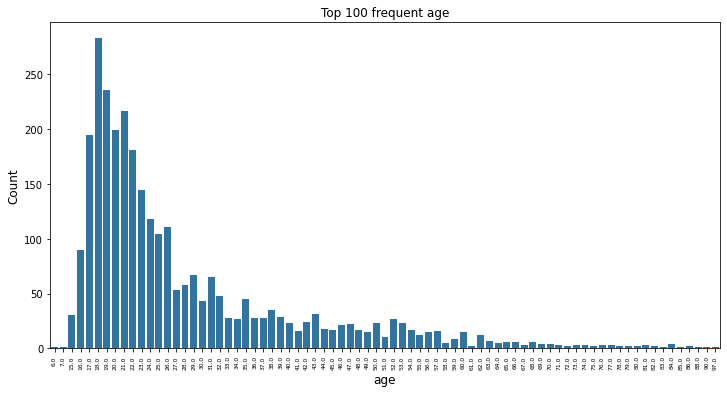

In [158]:
# Age plot


plot_df = df['age'].round().value_counts().iloc[:]
figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent age')
bp.set_xlabel("age", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

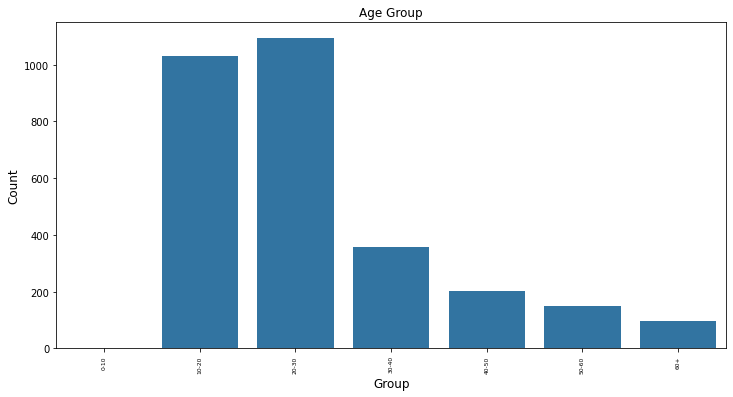

In [159]:
def plot_group_age(df):
    df_group = df.copy()
    df_group['age_group'] = pd.cut(df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 100], labels=['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60+'])
    plot_df = df_group['age_group'].value_counts().sort_index()
    
    figure, axis = plt.subplots(1, 1, figsize=(12, 6))
    bp = sns.barplot(ax=axis, x=plot_df.index, y=plot_df.values)
    bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)
    axis.set_title('Age Group')
    bp.set_xlabel("Group", fontsize=12)
    bp.set_ylabel("Count", fontsize=12)
    plt.show()

plot_group_age(df)

In [160]:
# Remove some ages
removed=df_dev[(df_dev['age']<10)|(df_dev['age']>=86)]
df_dev=df_dev[(df_dev['age']>10)&(df_dev['age']<86)]
df = pd.concat([df_dev, df_eval], sort=False)

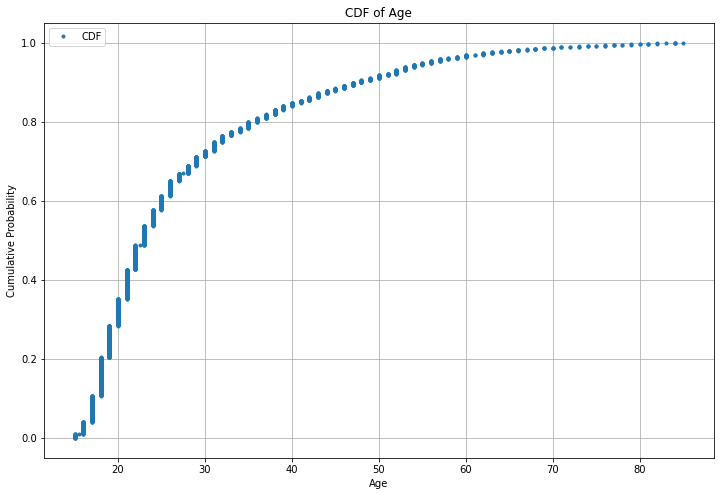

In [161]:
# CDF
data = df_dev['age'].sort_values()  
cdf = np.arange(1, len(data) + 1) / len(data) 
# Plot
plt.figure(figsize=(12, 8))
plt.plot(data, cdf, marker='.', linestyle='none', label='CDF')
plt.xlabel('Age')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Age')
plt.grid(True)
plt.legend()
plt.show()

String columns: ['gender', 'ethnicity', 'tempo', 'path']
Numeric_columns: ['sampling_rate', 'age', 'mean_pitch', 'max_pitch', 'min_pitch', 'jitter', 'shimmer', 'energy', 'zcr_mean', 'spectral_centroid_mean', 'hnr', 'num_words', 'num_characters', 'num_pauses', 'silence_duration']


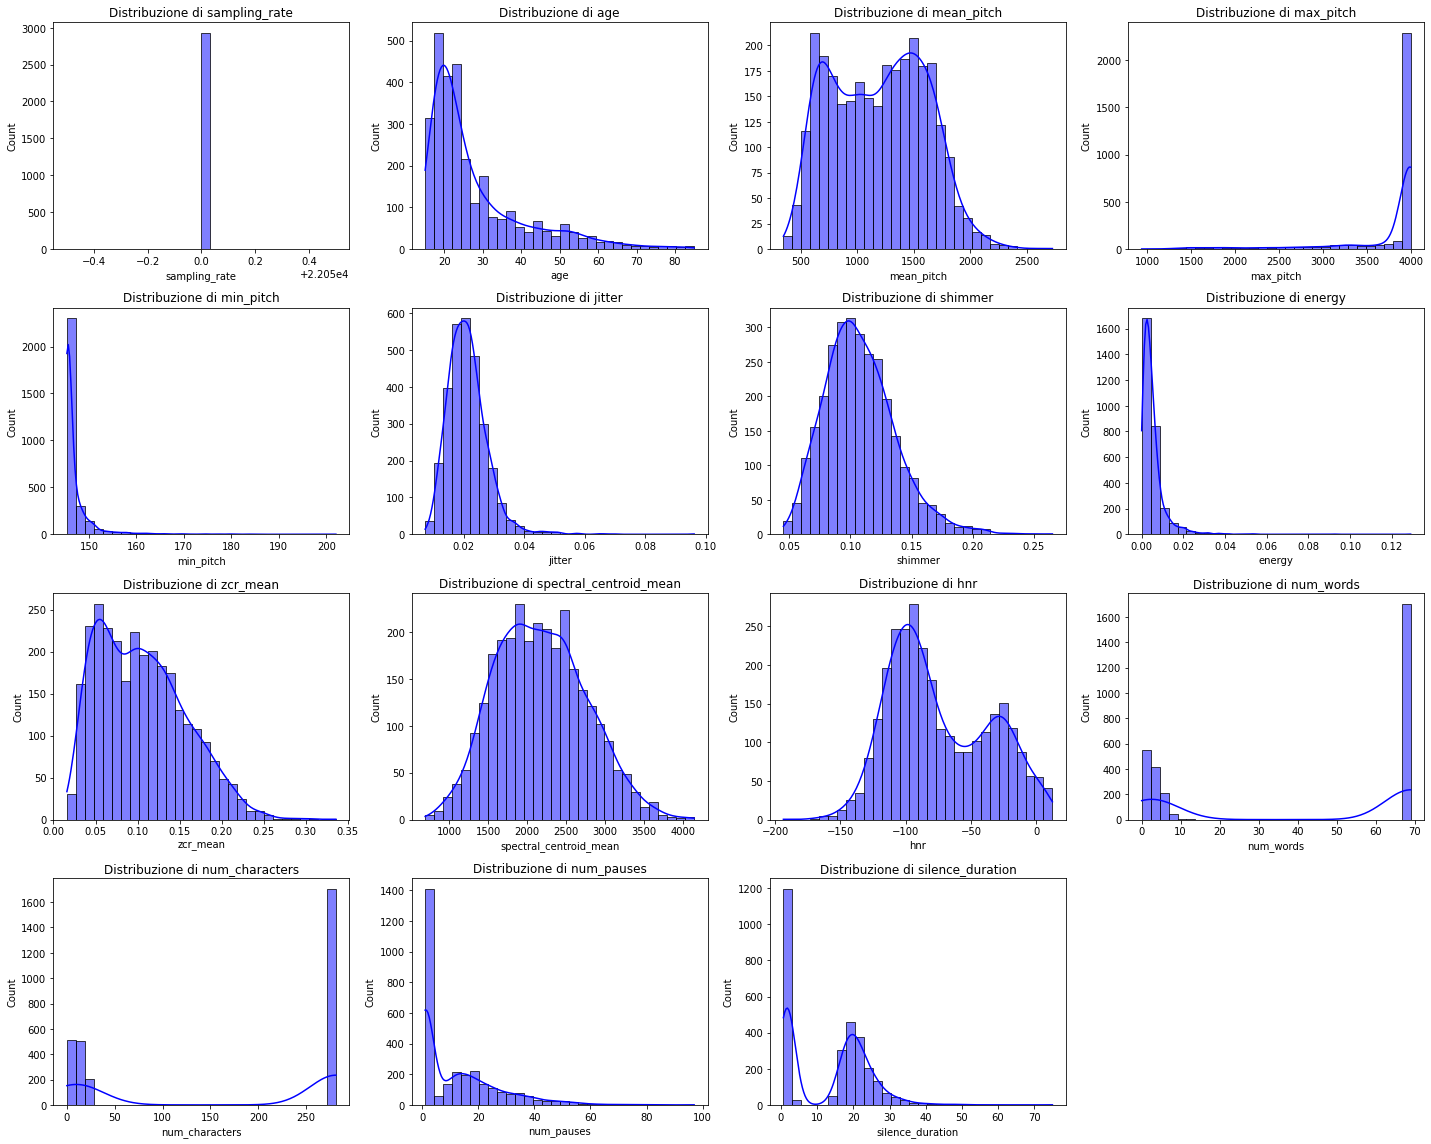

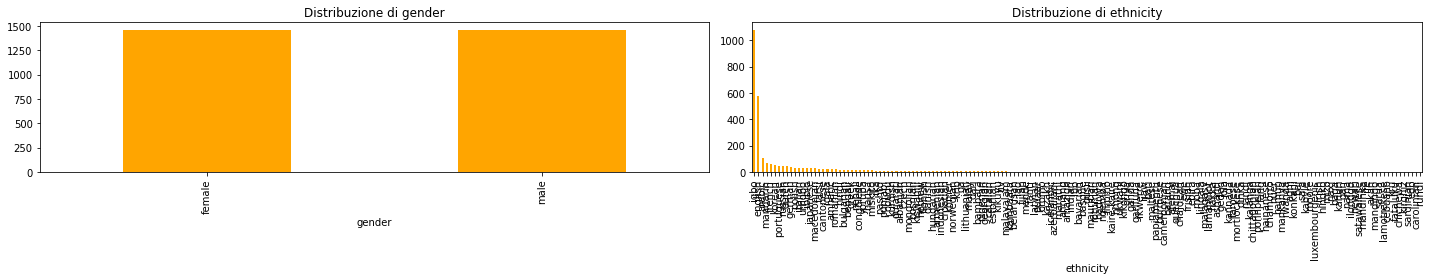

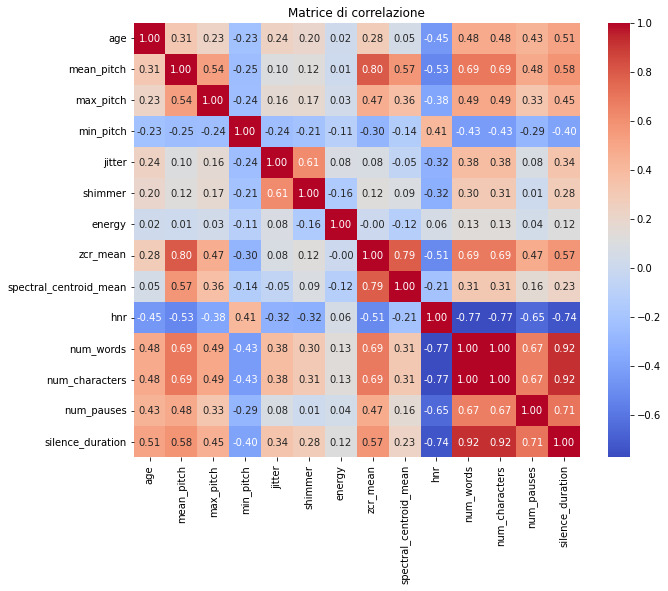

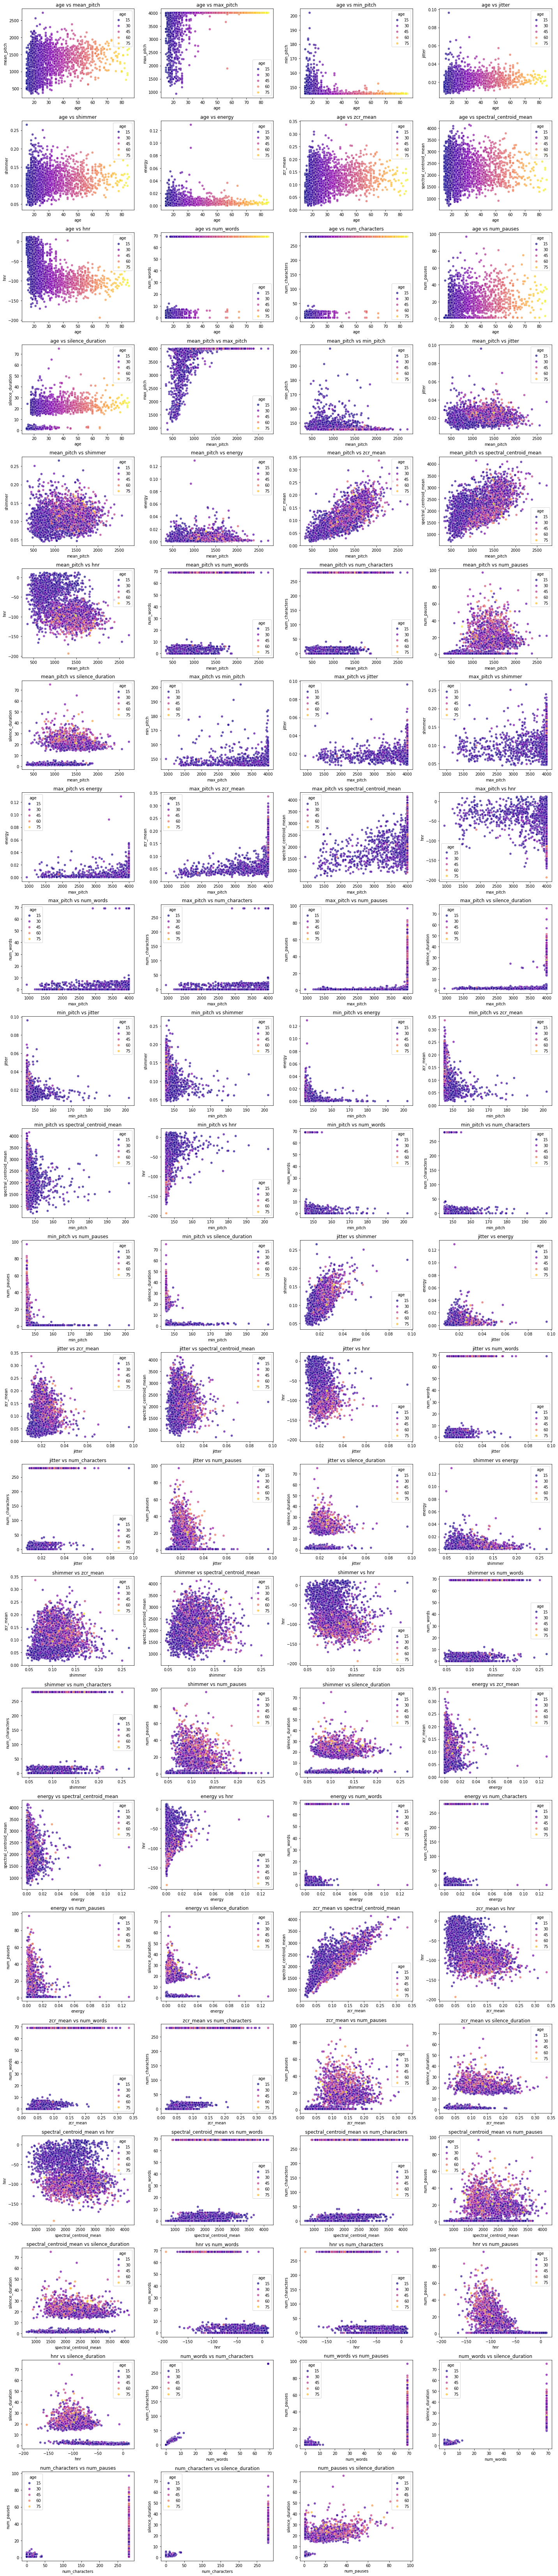

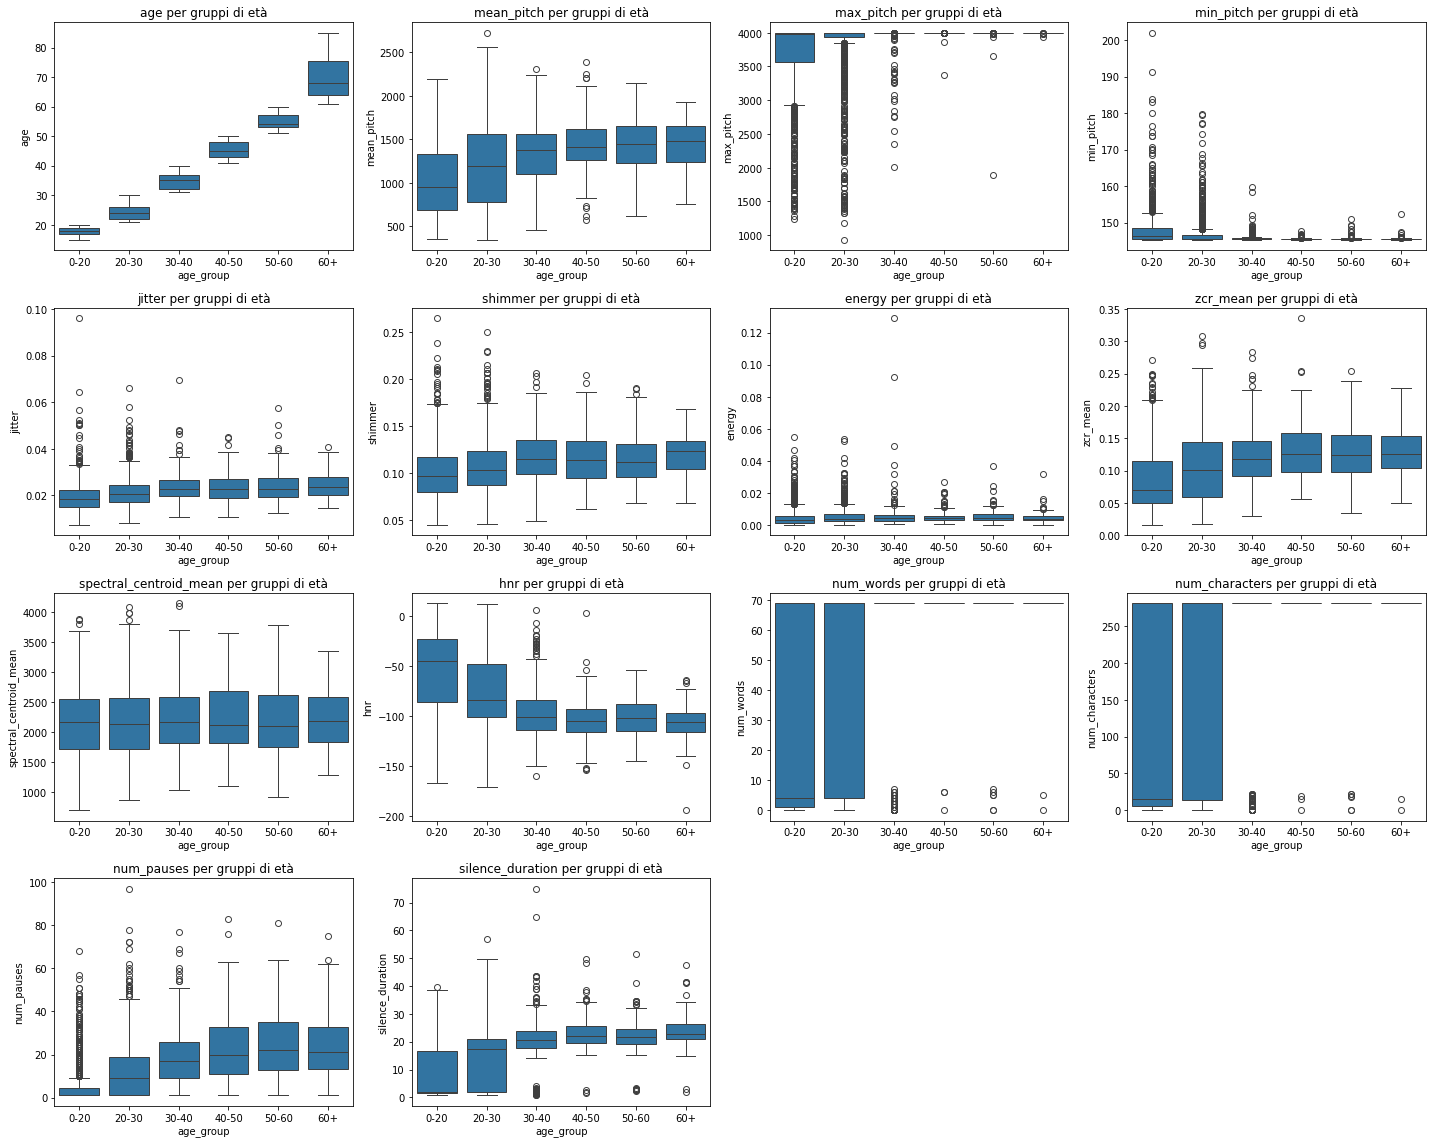

In [162]:
# Plot 

# Column analysis
def analyze_columns(df):
    column_types = df.dtypes
    string_columns = column_types[column_types == 'object'].index.tolist()
    numeric_columns = column_types[column_types != 'object'].index.tolist()
    print(f"String columns: {string_columns}")
    print(f"Numeric_columns: {numeric_columns}")
    return string_columns, numeric_columns


# Histogram
def plot_distributions(df, numeric_columns, string_columns):
    # Numeric_columns
    n_cols = 4
    n_rows = int(np.ceil(len(numeric_columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()
    for i, col in enumerate(numeric_columns):
        sns.histplot(df[col], kde=True, bins=30, color='blue', ax=axes[i])
        axes[i].set_title(f"Distribuzione di {col}")
    for i in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

    # String columns
    n_rows = int(np.ceil(len(string_columns) / n_cols))
    fig, axes = plt.subplots(n_rows, 2, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()
    for i, col in enumerate(string_columns):
        if col=='path' or col=='tempo':
            continue
        df[col].value_counts().plot(kind='bar', color='orange', ax=axes[i])
        axes[i].set_title(f"Distribuzione di {col}")
    for i in range(len(string_columns), len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()


# Correlation analysis
def correlation_analysis(df, numeric_columns):
    numeric_columns.remove('sampling_rate')
    # Correlation matrix
    corr_matrix = df[numeric_columns].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Matrice di correlazione")
    plt.show()
    n_cols = 4
    pairs = [(numeric_columns[i], numeric_columns[j]) for i in range(len(numeric_columns)) for j in range(i + 1, len(numeric_columns))]
    n_rows = int(np.ceil(len(pairs) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()
    custom_palette = sns.color_palette("plasma", as_cmap=True)
    for i, (col1, col2) in enumerate(pairs):
        sns.scatterplot(x=df[col1], y=df[col2], hue=df['age'], alpha=0.7, ax=axes[i], palette=custom_palette)
        axes[i].set_title(f"{col1} vs {col2}")
    for i in range(len(pairs), len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()
    
# Analyze age groups
def analyze_age_groups(df, age_column, numeric_columns):
    df_group = df.copy()
    df_group['age_group'] = pd.cut(df['age'], bins=[10, 20, 30, 40, 50, 60, 100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60+'])
    n_cols = 4
    n_rows = int(np.ceil(len(numeric_columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()
    for i, col in enumerate(numeric_columns):
        sns.boxplot(x='age_group', y=col, data=df_group, ax=axes[i])
        axes[i].set_title(f"{col} per gruppi di età")
    for i in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()

# Grouping all plots
def analyze_dataset(df):
    string_columns, numeric_columns = analyze_columns(df)
    plot_distributions(df, numeric_columns, string_columns)
    correlation_analysis(df, numeric_columns)
    analyze_age_groups(df, 'age', numeric_columns)

analyze_dataset(df_dev)


### Data Preprocessing

Several modifications have been made to the dataset to improve its suitability for the age estimation task. First, the **tempo** information, which was originally in a different format, has been converted into a float value for consistency and ease of use in modeling. Additionally, we have introduced a new feature, **words_per_second**, which represents the rate of spoken words within a given time frame. This feature is expected to be relevant for age estimation, as speech rate can vary significantly across different age groups.

To handle **categorical variables** effectively, we processed the gender and ethnicity columns. 

- The **gender** column has been transformed into a binary variable, gender_male, where male speakers are encoded as 1 and female speakers as 0.
- For the **ethnicity** feature, we applied one-hot encoding, creating separate binary columns for each ethnicity category. These transformations ensure that categorical variables are properly formatted for machine learning models while preserving their informative value.

In [163]:
df_dev_originale=df_dev.copy()
df_eval_originale=df_eval.copy()
df_originale=df.copy()


# 1. ENCODING GENDER
df['gender'] = df['gender'].replace('famale', 'female')
df= pd.get_dummies(df, columns=['gender'])
df= df.drop(columns=['gender_female'])

# 2. TIME INTO NUMBER
df['tempo'] = df['tempo'].apply(lambda x: float(x.strip('[]')))


In [164]:
# Function to calculate 'words_per_second'
def calculate_words_per_second(df, audio_data):
    words_per_second = []
    for index, row in df.iterrows():
        y, sr = audio_data[row['path']]
        duration = len(y) / sr
        words_per_second_ = row['num_words'] / duration
        words_per_second.append(words_per_second_)
    return np.array(words_per_second)

# Function to load all audio files
def load_audio_files(df):
    audio_data = {}
    for index, row in df.iterrows():
        fname = row['path']
        y, sr = librosa.load(fname, sr=22050)
        audio_data[row['path']] = (y, sr)
    return audio_data

audio_data = load_audio_files(df)
df_dev = df[df['age'].notna()]
df_eval = df[df['age'].isna()]


df_dev['words_per_second'] = calculate_words_per_second(df_dev,audio_data)
df_eval['words_per_second'] = calculate_words_per_second(df_eval,audio_data)

df = pd.concat([df_dev, df_eval], sort=False)


In [165]:
df

sampling_rate   age   ethnicity  mean_pitch  max_pitch  min_pitch  \
Id                                                                       
0            22050  24.0      arabic  1821.69060  3999.7170  145.43066   
1            22050  22.5   hungarian  1297.81870  3998.8590  145.37268   
2            22050  22.0  portuguese  1332.85240  3998.8025  145.42395   
3            22050  22.0     english  1430.34990  3998.4510  147.98083   
4            22050  22.0       dutch  1688.72340  3998.6113  145.44772   
..             ...   ...         ...         ...        ...        ...   
686          22050   NaN        igbo   570.62740  3900.6730  145.67577   
687          22050   NaN        igbo   974.13965  3919.0024  145.90408   
688          22050   NaN     serbian  1113.27650  3999.3510  145.38307   
689          22050   NaN     spanish  1759.17420  3999.4610  145.56773   
690          22050   NaN        igbo   779.53890  3972.4630  147.44424   

       jitter   shimmer    energy  zcr_mean  spectral_centroid_mean  \
Id                                                                    
0    0.013795  0.082725  0.002254  0.210093             3112.257251   
1    0.025349  0.096242  0.007819  0.078849             1688.016389   
2    0.019067  0.119456  0.002974  0.105365             2576.901706   
3    0.017004  0.102389  0.022371  0.173701             3269.751413   
4    0.028027  0.124831  0.005369  0.107279             1930.897375   
..        ...       ...       ...       ...                     ...   
686  0.018842  0.079197  0.004545  0.072083             1946.502158   
687  0.024367  0.117492  0.000878  0.076900             3319.620800   
688  0.020637  0.089355  0.009148  0.095613             1973.127197   
689  0.026118  0.106429  0.003707  0.141474             2137.517812   
690  0.010952  0.108114  0.003370  0.083540             2530.285199   

          tempo         hnr  num_words  num_characters  num_pauses  \
Id                                                                   
0    151.999081 -123.999726         69             281          39   
1    129.199219  -86.928478         69             281          21   
2    117.453835  -98.450670         69             281           1   
3    117.453835  -56.459762         69             281           9   
4    112.347147  -80.349204         69             281          11   
..          ...         ...        ...             ...         ...   
686  112.347147  -42.895295          6              15           1   
687  112.347147 -144.881089          7              22           1   
688  112.347147  -73.559944         69             281          15   
689  117.453835  -93.562873         69             281          10   
690  184.570312  -35.776665          5              19           1   

     silence_duration                       path  gender_male  \
Id                                                              
0           23.846893   audios_development/1.wav        False   
1           19.388662   audios_development/2.wav        False   
2           21.640998   audios_development/3.wav        False   
3           19.644127   audios_development/4.wav        False   
4           18.041905   audios_development/5.wav         True   
..                ...                        ...          ...   
686          1.861950  audios_evaluation/687.wav         True   
687          4.876190  audios_evaluation/688.wav         True   
688         25.541950  audios_evaluation/689.wav        False   
689         20.967619  audios_evaluation/690.wav         True   
690          1.230658  audios_evaluation/691.wav         True   

     words_per_second  
Id                     
0            1.966079  
1            2.957402  
2            3.184435  
3            3.069810  
4            3.614402  
..                ...  
686          2.963710  
687          1.414939  
688          2.510432  
689          3.189623  
690          3.960841  

[3617 rows x 20 columns]

In [166]:
# 3. REMOVE IRRELEVANT FEATURES OR FEATURES WITH CORRELATION 1
lista=['sampling_rate','num_words'] 
df = df.drop(columns=lista)


# 4. ENCODING ETHNICITY
df_copy=df.copy()
df_encoding = df.copy()
threshold = 10
ethnicity_counts = df_copy['ethnicity'].value_counts()
rare_ethnicities = ethnicity_counts[ethnicity_counts < threshold].index
df_copy['ethnicity'] = df_copy['ethnicity'].replace(rare_ethnicities, 'Other')
df_copy['ethnicity'].value_counts()
df_encoding = pd.get_dummies(df_copy, columns=['ethnicity'])



When applying one-hot encoding to the ethnicity feature, we decided to group all ethnicities represented by fewer than 10 speakers into a single category labeled 'Others'. This decision was made to reduce the number of generated features  and to prevent the model from learning from underrepresented categories that might not provide reliable patterns due to insufficient data. 

To validate this approach, we compared regression performance using both encoding strategies: one where all ethnicities were individually represented and another where low-frequency categories were grouped into 'Others'. After running the regression models, we observed that the approach with the 'Others' category resulted in a lower RMSE. 

Additionally, we decided to remove features **path** and **sampling_rate**, always equals to 22050, as they provided no meaningful information for the prediction task. Furthermore, the **num_words** feature was excluded due to its perfect correlation with num_characters, making it redundant.

### Models

In [167]:
### WRITE A FUNCTION TO CALL THE MODEL DIRECTLY GIVEN THE DATASET
# Simple models: baseline, k-fold e k-fold+log
from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt


def modello_semplice(df,random_state=0): 
    # Separate the dataset into training and test set
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]

    # Prepare features and target
    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])
    
    # Divide training set in training and validation set
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, shuffle=True, random_state=random_state)
    
    # Train the model
    reg = RandomForestRegressor(100, random_state=random_state)
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_valid)

    r2 = r2_score(y_valid, y_pred)
    print(f"r2_score: {r2}")
    
    rmse = sqrt(mean_squared_error(y_valid, y_pred))
    print(f"RMSE: {rmse}")
    
    return reg,y_valid.to_numpy(),y_pred


def modello_semplice_kfold(df, n_splits=5, random_state=0):
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]

    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    y_valid_lista=[]
    y_pred_lista=[]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
        # Split data
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)

        reg = RandomForestRegressor(100, random_state=random_state)
        reg.fit(X_train, y_train)

        # prediction on validation set
        y_pred = reg.predict(X_valid)
        y_pred_lista.append(y_pred)

        # Score metrics
        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))

        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    # Average results
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    return reg, y_valid_lista, y_pred_lista


def modello_semplice_kfold_log(df, n_splits=5, random_state=0): 
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]

    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    y_valid_lista=[]
    y_pred_lista=[]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
       
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)
        
        reg = RandomForestRegressor(100, random_state=random_state)
        threshold_max=50
        threshold_min=1
       
        weights = np.where(y_train < threshold_min, 3, np.where(y_train > threshold_max, 3, 1))
        reg.fit(X_train,  np.log1p(y_train),sample_weight=weights)

        y_pred_log = reg.predict(X_valid)
        y_pred=np.expm1(y_pred_log)
        
        y_pred_lista.append(y_pred)

        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))

        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    return reg, y_valid_lista, y_pred_lista

In [168]:
### Improved model

from scipy.stats import boxcox

def modello_migliore_kfold_no_pesi(df, n_splits=5, random_state=0): 
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]

    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    y_valid_lista = []
    y_pred_lista = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)
        
        reg = RandomForestRegressor(
                   n_estimators=200, 
                   max_depth=10, 
                   min_samples_leaf=5, 
                   random_state=random_state)

        # Transformation
        y_train_transformed= y_train  
        y_train_transformed = np.log1p(y_train)
        reg.fit(X_train, y_train_transformed)

        y_pred_transformed = reg.predict(X_valid)
        y_pred = np.expm1(y_pred_transformed)
        y_pred_lista.append(np.array(y_pred))
        
        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")

    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    return reg, y_valid_lista, y_pred_lista


In [169]:
### K-fold

def modello_migliore_kfold(df, n_splits=5, random_state=0): 
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]

    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    y_valid_lista = []
    y_pred_lista = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)
        
        reg = RandomForestRegressor(
                   n_estimators=200, 
                   max_depth=10, 
                   min_samples_leaf=5, 
                   random_state=random_state)
        threshold_max=50
        weights = np.where(y_train > threshold_max, 4, 1)
        y_train_transformed= y_train 
        y_train_transformed = np.log1p(y_train)
        reg.fit(X_train, y_train_transformed,sample_weight=weights)

        y_pred_transformed = reg.predict(X_valid)

        y_pred=y_pred_transformed
        y_pred = np.expm1(y_pred_transformed)
        y_pred_lista.append(np.array(y_pred))
        
        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    # Train with all dataset
    reg = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=random_state)
    weights = np.where(y_train_valid > threshold_max, 4, 1)
    y_train_transformed= np.log1p(y_train_valid)
    reg.fit(X_train_valid, y_train_transformed,sample_weight=weights)
    return reg, y_valid_lista, y_pred_lista


In [180]:
from sklearn.model_selection import StratifiedKFold

def modello_migliore_kfold_stratified(df, n_splits=5, random_state=0):
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]
    train = train.copy()
    train.loc[:, 'label_age'] = pd.cut(train['age'], bins=[-np.inf, 20, 30, 40, 50, 60, 70, 80, np.inf], labels=[0, 1, 2, 3, 4, 5, 6, 7])

    X_train_valid = train.drop(columns=["age","label_age"])
    y_train_valid = train["age"]
    label_age= train["label_age"]
    X_test = test.drop(columns=["age"])
    
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    y_valid_lista = []
    y_pred_lista = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid,label_age)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)

        reg = RandomForestRegressor(
                   n_estimators=200, 
                   max_depth=10, 
                   min_samples_leaf=5, 
                   random_state=random_state)
   
 
        threshold=50       
        weights = np.where(y_train > threshold, 4, 1)

        y_train_transformed = np.log1p(y_train)
        reg.fit(X_train, y_train_transformed,sample_weight=weights)
        y_pred_transformed = reg.predict(X_valid)
        y_pred = np.expm1(y_pred_transformed)
        y_pred_lista.append(np.array(y_pred))
        
        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    reg = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=random_state)
    weights = np.where(y_train_valid > threshold, 4, 1)
    y_train_transformed= np.log1p(y_train_valid)
    reg.fit(X_train_valid, y_train_transformed,sample_weight=weights)
    
    return reg, y_valid_lista, y_pred_lista



In [171]:

def modello_migliore_kfold_stratified_normalizzato(df, n_splits=5, random_state=0):
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]
    train = train.copy()
    train.loc[:, 'label_age'] = pd.cut(train['age'], bins=[-np.inf, 20, 30, 40, 50, 60, 70, 80, np.inf], labels=[0, 1, 2, 3, 4, 5, 6, 7])

    X_train_valid = train.drop(columns=["age","label_age"])
    y_train_valid = train["age"]
    label_age= train["label_age"]
    X_test = test.drop(columns=["age"])
    
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=random_state)
    scaler = StandardScaler()
    
    r2_scores = []
    rmses = []
    y_valid_lista = []
    y_pred_lista = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid,label_age)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)
        X_train_norm = scaler.fit_transform(X_train)
        X_valid_norm = scaler.transform(X_valid)
        
        reg = RandomForestRegressor(
                   n_estimators=200, 
                   max_depth=10, 
                   min_samples_leaf=5, 
                   random_state=random_state)
    
        threshold=50 
        weights = np.where(y_train > threshold, 4, 1)
        y_train_transformed = np.log1p(y_train)
        reg.fit(X_train_norm, y_train_transformed,sample_weight=weights)
        y_pred_transformed = reg.predict(X_valid_norm)

        y_pred = np.expm1(y_pred_transformed)
        y_pred_lista.append(np.array(y_pred))

        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")

    reg = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=random_state)
    weights = np.where(y_train_valid > threshold, 4, 1)
    y_train_transformed= np.log1p(y_train_valid)
    X_train_valid_norm = scaler.fit_transform(X_train_valid)
    reg.fit(X_train_valid_norm, y_train_transformed,sample_weight=weights)
    
    return reg, y_valid_lista, y_pred_lista


In [172]:
def plot_previsioni(y_valid_lista,y_pred_lista,differenza=10):
    
    for i in range(len(y_valid_lista)):
        print(f'Fold {i+1}:')
        actual=y_valid_lista[i].to_numpy()
        predicted=y_pred_lista[i]
        difference = abs(actual - predicted)
        mask = difference > differenza
        filtered_actual = actual[mask]
        filtered_predicted = predicted[mask]
        plt.figure(figsize=(20, 6))
        plt.plot(filtered_actual, label='Effettivi', marker='o')
        plt.plot(filtered_predicted, label='Previsti', marker='x')
        plt.title(f'Valori Effettivi vs Previsti (Differenza > {differenza})')
        plt.xlabel('Indice')
        plt.ylabel('Valore')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        y_pred=predicted
        y_valid=actual
        plt.figure(figsize=(8, 6))
        plt.scatter(y_valid, y_pred, color='blue', alpha=0.7, label='Previsioni vs Veri Valori')
        plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], color='red', linestyle='--', label='Linea di Equivalenza')
        plt.xlabel('Valori Veri')
        plt.ylabel('Valori Predetti')
        plt.title('Regressione - Valori Veri vs Predetti')
        plt.legend()
        plt.grid(True)
        plt.show()
        


In [174]:
# OVERSAMPLING and UNDERSAMPLING

# OVERSAMPLING
def oversample_data(X, y, oversample_factor=2,random_state=0,target=50,fract=1):
    data = pd.concat([X, y], axis=1)
    data_over_50 = data[data["age"] > target]
    data_other = data[data["age"] <= target]
    synthetic_samples = []
    for _ in range(oversample_factor - 1):  
        sample_1 = data_over_50.sample(frac=fract, replace=True, random_state=random_state).reset_index(drop=True)
        sample_2 = data_over_50.sample(frac=fract, replace=True, random_state=random_state).reset_index(drop=True)
        alpha = np.random.rand(len(sample_1)) 
        synthetic = sample_1 * alpha[:, None] + sample_2 * (1 - alpha[:, None])
        synthetic_samples.append(synthetic)
    if synthetic_samples:
        synthetic_data = pd.concat(synthetic_samples, axis=0).reset_index(drop=True)
    else:
        synthetic_data = pd.DataFrame(columns=data.columns)  
    data_resampled = pd.concat([data_other, data_over_50, synthetic_data], axis=0).reset_index(drop=True)
    X_resampled = data_resampled.drop(columns=["age"])
    y_resampled = data_resampled["age"]
    
    return X_resampled, y_resampled


# UNDERSAMPLING 
def undersample_data(X, y,target_col='age', sampling_factor=0.5,random_state=0,target=30):
    data = pd.concat([X, y], axis=1)
    data_above = data[data[target_col] > target]  
    data_below = data[data[target_col] <= target]  
    
    if not data_below.empty:
        n_samples = max(1, int(len(data_below) * sampling_factor)) 
        data_below_resampled = data_below.sample(n=n_samples, random_state=random_state)
    else:
        data_below_resampled = pd.DataFrame(columns=data.columns)  
    data_resampled = pd.concat([data_above, data_below_resampled], axis=0).reset_index(drop=True)

    X_resampled = data_resampled.drop(columns=[target_col])
    y_resampled = data_resampled[target_col]
    
    return X_resampled, y_resampled



def modello_migliore_kfold_oversampling(df, n_splits=5, random_state=0,target=50):
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]

    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        X_train_oversampled, y_train_oversampled = oversample_data(X_train, y_train,oversample_factor=2,random_state=0,target=target,fract=0.8) 
        reg = RandomForestRegressor(
                   n_estimators=200, 
                   max_depth=10, 
                   min_samples_leaf=5, 
                   random_state=random_state)
        threshold_max=50
        threshold_min=20
        weights = np.where(y_train_oversampled > threshold_max, 4, 1)
        weights = np.where(y_train_oversampled > threshold_max, 2, 1)
        y_train_transformed = np.log1p(y_train_oversampled)
        reg.fit(X_train_oversampled, y_train_transformed,sample_weight=weights)
        y_pred_transformed = reg.predict(X_valid)
        y_pred = np.expm1(y_pred_transformed)
        
        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))

        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
        
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    return reg, r2_scores, rmses


def modello_migliore_kfold_undersampling(df, n_splits=5, random_state=0,target=20):
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]
    
    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        
        X_train_undersampled, y_train_undersampled = undersample_data(X_train, y_train,target_col='age', sampling_factor=0.9,random_state=0,target=target)

        reg = RandomForestRegressor(
                   n_estimators=200, 
                   max_depth=10, 
                   min_samples_leaf=5, 
                   random_state=random_state)
        threshold_max=50
        threshold_min=20     
        weights = np.where(y_train_undersampled > threshold_max, 4, 1)
        y_train_transformed = np.log1p(y_train_undersampled)
        reg.fit(X_train_undersampled, y_train_transformed,sample_weight=weights)
        y_pred_transformed = reg.predict(X_valid)
        y_pred=y_pred_transformed
        y_pred = np.expm1(y_pred_transformed)
        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))

        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")

    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    return reg, r2_scores, rmses


def modello_migliore_kfold_sampling(df, n_splits=5, random_state=0,target1=20,target2=50):
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]

    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        X_train_oversampled, y_train_oversampled = oversample_data(X_train, y_train,oversample_factor=2,random_state=0,target=target2,fract=0.9)
        X_train_undersampled, y_train_undersampled = undersample_data(X_train_oversampled, y_train_oversampled,target_col='age', sampling_factor=0.9,random_state=0,target=target1)
        reg = RandomForestRegressor(
                   n_estimators=200, 
                   max_depth=10, 
                   min_samples_leaf=5, 
                   random_state=random_state)
        threshold_max=50
        threshold_min=20
        weights = np.where(y_train_undersampled > threshold_max, 3, 1)
        y_train_transformed = np.log1p(y_train_undersampled)
        reg.fit(X_train_undersampled, y_train_transformed,sample_weight=weights)
        y_pred_transformed = reg.predict(X_valid)
        y_pred = np.expm1(y_pred_transformed)
        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))

        r2_scores.append(r2)
        rmses.append(rmse)
        
        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    

In [175]:
def top_features_df(df, reg, num_features):
    copia=df.copy()
    copia=copia.drop(columns=['age'])
    feature_names = copia.columns
    feature_importances = pd.Series(reg.feature_importances_, feature_names).sort_values(ascending=False)
    top_features_ = feature_importances.head(num_features).index
    top_features = top_features_.append(pd.Index(['age']))
    
    return df[top_features], top_features_,feature_importances


### Try different models

In [176]:
df_encoding_copy=df_encoding.copy()
df_encoding_copy=df_encoding_copy.drop(columns=['path'])

In [177]:
df_senza_entie=df.copy()
df_senza_entie=df_senza_entie.drop(columns=['ethnicity','path'])

In [178]:
print('RIMUOVENDO ETNIE')
print('\n Modello semplice k fold: ')
reg=modello_semplice_kfold(df_senza_entie)
print('\n Modello semplice k fold e log: ')
modello_semplice_kfold_log(df_senza_entie)

print('ENCODING ETNIE')
print('\n Modello semplice k fold: ')
reg=modello_semplice_kfold(df_encoding_copy)
print('\n Modello semplice k fold e log: ')
modello_semplice_kfold_log(df_encoding_copy)
print()

RIMUOVENDO ETNIE

 Modello semplice k fold: 
Fold 1: r2_score = 0.3145, RMSE = 10.0201
Fold 2: r2_score = 0.3132, RMSE = 11.6433
Fold 3: r2_score = 0.2722, RMSE = 10.9431
Fold 4: r2_score = 0.3429, RMSE = 10.0061
Fold 5: r2_score = 0.2940, RMSE = 10.7143

Mean r2_score: 0.3074
Mean RMSE: 10.6654

 Modello semplice k fold e log: 
Fold 1: r2_score = 0.3602, RMSE = 9.6806
Fold 2: r2_score = 0.3002, RMSE = 11.7531
Fold 3: r2_score = 0.2913, RMSE = 10.7987
Fold 4: r2_score = 0.3639, RMSE = 9.8450
Fold 5: r2_score = 0.3086, RMSE = 10.6034

Mean r2_score: 0.3248
Mean RMSE: 10.5362
ENCODING ETNIE

 Modello semplice k fold: 
Fold 1: r2_score = 0.3719, RMSE = 9.5914
Fold 2: r2_score = 0.3818, RMSE = 11.0465
Fold 3: r2_score = 0.3173, RMSE = 10.5988
Fold 4: r2_score = 0.3653, RMSE = 9.8347
Fold 5: r2_score = 0.3835, RMSE = 10.0121

Mean r2_score: 0.3640
Mean RMSE: 10.2167

 Modello semplice k fold e log: 
Fold 1: r2_score = 0.3992, RMSE = 9.3809
Fold 2: r2_score = 0.3626, RMSE = 11.2162
Fold 3: r

### Model comparison


 Modello semplice k fold: 
Fold 1: r2_score = 0.3719, RMSE = 9.5914
Fold 2: r2_score = 0.3818, RMSE = 11.0465
Fold 3: r2_score = 0.3173, RMSE = 10.5988
Fold 4: r2_score = 0.3653, RMSE = 9.8347
Fold 5: r2_score = 0.3835, RMSE = 10.0121

Mean r2_score: 0.3640
Mean RMSE: 10.2167

 Modello semplice k fold e log: 
Fold 1: r2_score = 0.3992, RMSE = 9.3809
Fold 2: r2_score = 0.3626, RMSE = 11.2162
Fold 3: r2_score = 0.3242, RMSE = 10.5447
Fold 4: r2_score = 0.3843, RMSE = 9.6861
Fold 5: r2_score = 0.3896, RMSE = 9.9626

Mean r2_score: 0.3720
Mean RMSE: 10.1581

 Modello migliore k fold No pesi: 
Fold 1: r2_score = 0.3862, RMSE = 9.4819
Fold 2: r2_score = 0.3550, RMSE = 11.2830
Fold 3: r2_score = 0.3476, RMSE = 10.3609
Fold 4: r2_score = 0.3888, RMSE = 9.6504
Fold 5: r2_score = 0.3748, RMSE = 10.0829

Mean r2_score: 0.3705
Mean RMSE: 10.1718

 Modello migliore k fold: 
Fold 1: r2_score = 0.3902, RMSE = 9.4511
Fold 2: r2_score = 0.3860, RMSE = 11.0084
Fold 3: r2_score = 0.3331, RMSE = 10.4754


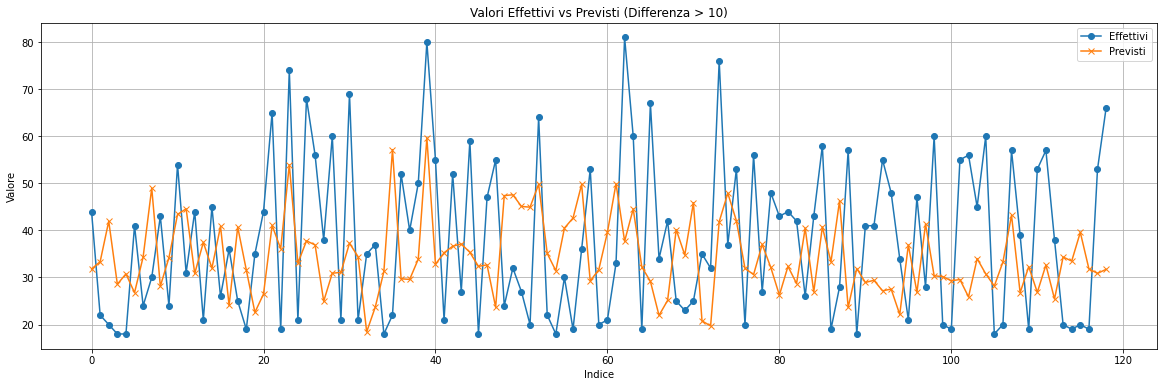

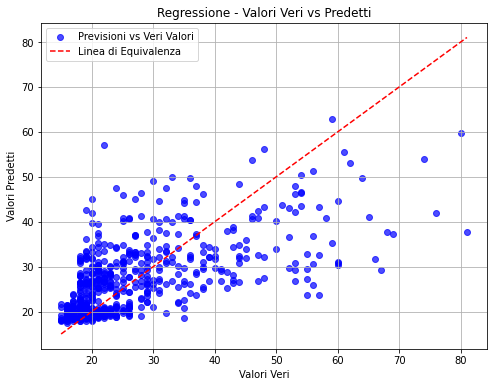

Fold 2:


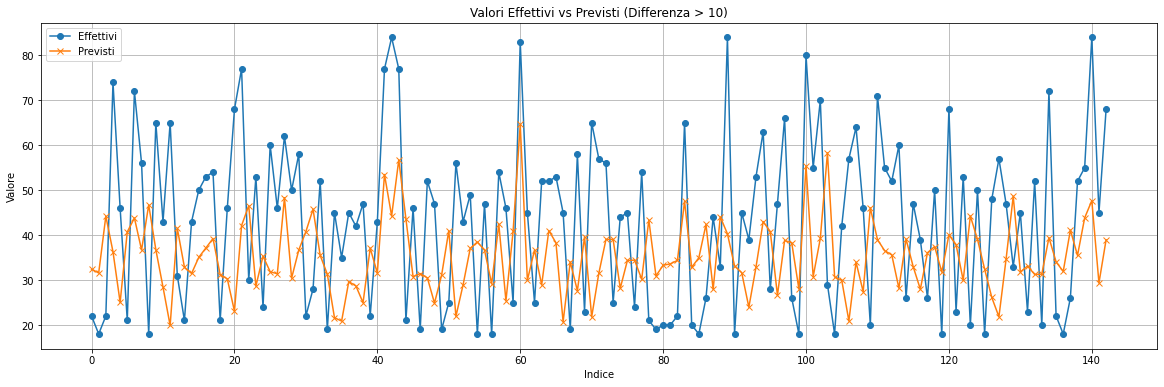

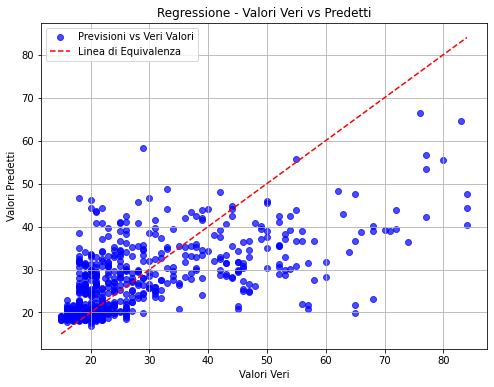

Fold 3:


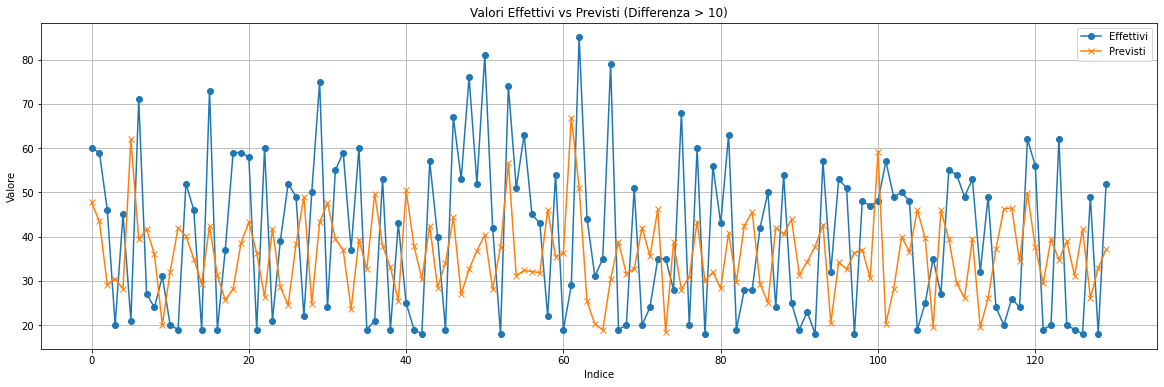

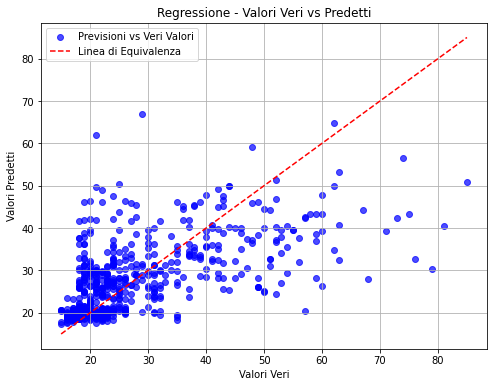

Fold 4:


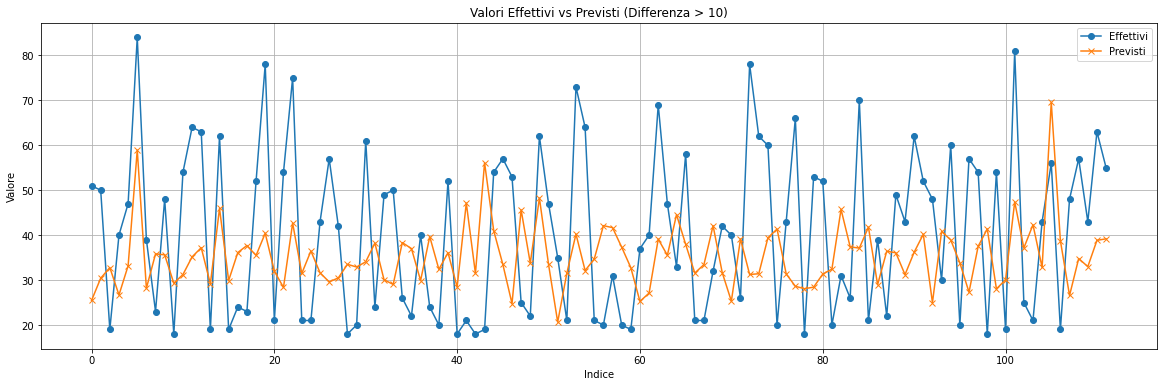

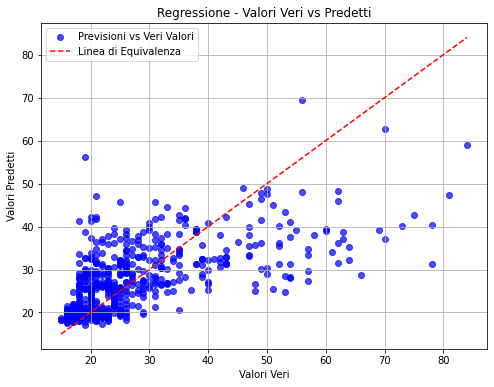

Fold 5:


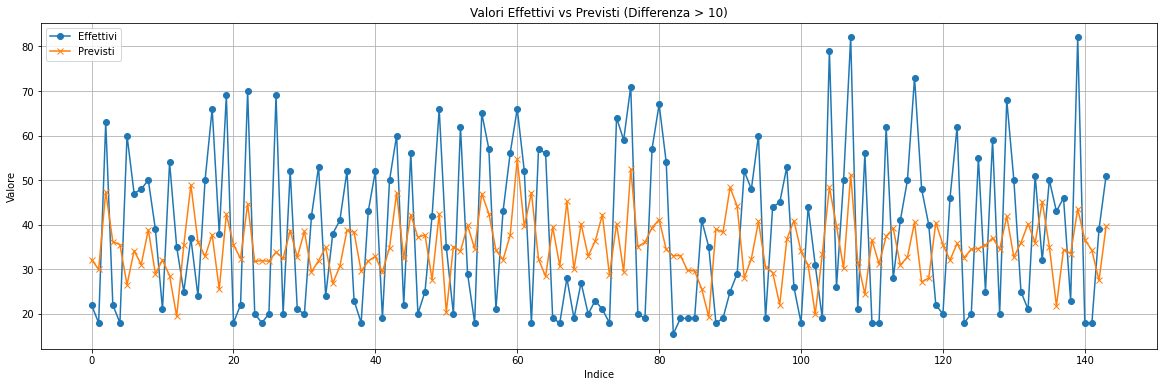

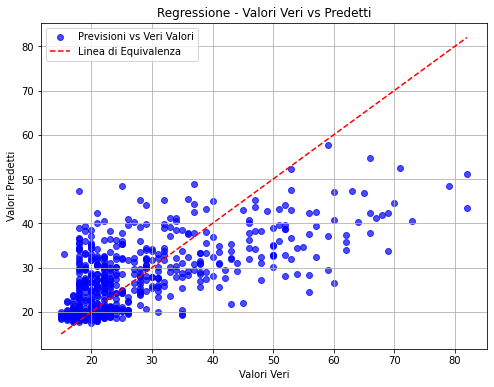

Fold 1: r2_score = 0.3897, RMSE = 9.4543
Fold 2: r2_score = 0.3859, RMSE = 11.0099
Fold 3: r2_score = 0.3327, RMSE = 10.4784
Fold 4: r2_score = 0.4075, RMSE = 9.5021
Fold 5: r2_score = 0.4198, RMSE = 9.7129

Mean r2_score: 0.3871
Mean RMSE: 10.0315
Fold 1: r2_score = 0.3540, RMSE = 10.2233
Fold 2: r2_score = 0.4432, RMSE = 9.5861
Fold 3: r2_score = 0.3592, RMSE = 10.3465
Fold 4: r2_score = 0.3672, RMSE = 10.1976
Fold 5: r2_score = 0.3727, RMSE = 10.2235

Mean r2_score: 0.3793
Mean RMSE: 10.1154



silence_duration          0.465135
words_per_second          0.117631
ethnicity_english         0.050403
jitter                    0.047862
hnr                       0.043304
shimmer                   0.036085
spectral_centroid_mean    0.033165
energy                    0.031542
min_pitch                 0.029683
mean_pitch                0.028221
zcr_mean                  0.027155
num_pauses                0.026607
max_pitch                 0.023950
tempo                     0.019803
gender_male               0.007897
ethnicity_congolese       0.002479
ethnicity_arabic          0.002017
ethnicity_miskito         0.001558
ethnicity_Other           0.001526
num_characters            0.001095
ethnicity_italian         0.000419
ethnicity_mandarin        0.000374
ethnicity_russian         0.000346
ethnicity_japanese        0.000331
ethnicity_french          0.000231
ethnicity_macedonian      0.000226
ethnicity_cantonese       0.000199
ethnicity_obudu           0.000148
ethnicity_korean    

In [181]:

df_prima_di_rimuovere_outlier=df_encoding.copy()
df_prima_di_rimuovere_outlier=df_prima_di_rimuovere_outlier.drop(columns=['path'])

print('\n Modello semplice k fold: ')
reg=modello_semplice_kfold(df_prima_di_rimuovere_outlier)
print('\n Modello semplice k fold e log: ')
modello_semplice_kfold_log(df_prima_di_rimuovere_outlier)
print('\n Modello migliore k fold No pesi: ')
modello_migliore_kfold_no_pesi(df_prima_di_rimuovere_outlier)
print('\n Modello migliore k fold: ')
reg,y_valid_lista,y_pred_lista=modello_migliore_kfold(df_prima_di_rimuovere_outlier)
print('\n Modello migliore k fold stratified: ')
modello_migliore_kfold_stratified(df_prima_di_rimuovere_outlier)
print('\n Modello migliore k fold oversampling: ')
modello_migliore_kfold_oversampling(df_prima_di_rimuovere_outlier)
print('\n Modello migliore k fold undersampling: ')
modello_migliore_kfold_undersampling(df_prima_di_rimuovere_outlier)
print('\n Modello migliore k fold oversampling e undersampling: ')
modello_migliore_kfold_sampling(df_prima_di_rimuovere_outlier)
print('Improved sampling')
modello_migliore_kfold_oversampling(df_prima_di_rimuovere_outlier,target=65) #target=65 10.0586 # PESI = 2
modello_migliore_kfold_undersampling(df_prima_di_rimuovere_outlier,target=40) # target=40 10.0337 # PESI = 4
modello_migliore_kfold_sampling(df_prima_di_rimuovere_outlier,target1=40,target2=70) #10.0305 target1=40,target2=70 # PESI = 3

# Displaying the best forecasts
plot_previsioni(y_valid_lista,y_pred_lista)


# Extract feature importances
df_copy=df_encoding_copy.copy()
df_copy=df_copy.drop(columns=['age'])
feature_names = df_copy.columns
feature_importances = pd.Series(reg.feature_importances_, feature_names).sort_values(ascending=False)

df_top_features, top_features_,feature_importances = top_features_df(df_encoding_copy, reg, 50)

reg_top,y_valid,y_pred=modello_migliore_kfold(df_top_features)
modello_migliore_kfold_stratified(df_top_features)
print()

pd.Series(reg_top.feature_importances_, top_features_).sort_values(ascending=False)

### Outlier

To improve data quality and ensure a more robust model, we initially identified and removed some outliers by analyzing attribute distributions and box plots.

In [182]:
# 5. Management of outliers
df=df_encoding.copy()
df_dev = df[df['age'].notna()]
df_eval = df[df['age'].isna()]

# Different type of distributions
colonne_outlier=['mean_pitch','jitter','shimmer','zcr_mean','spectral_centroid_mean','tempo']
colonne_zero_neg=['num_pauses','silence_duration','num_characters']
altre_colonne=['max_pitch','min_pitch','energy','hnr']

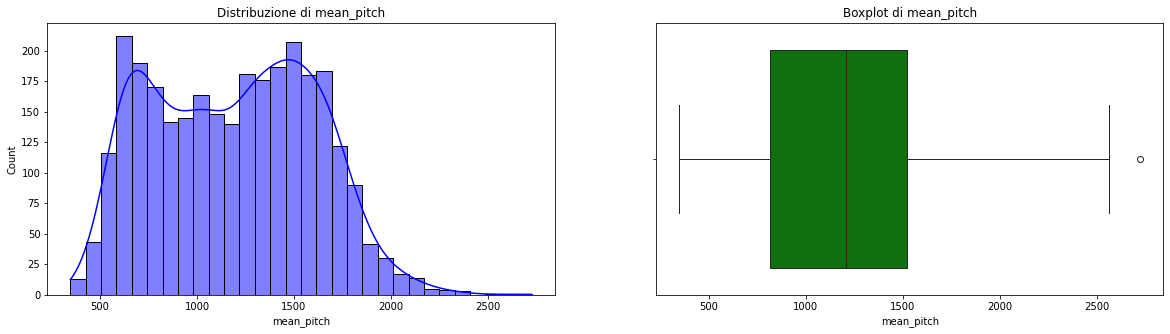

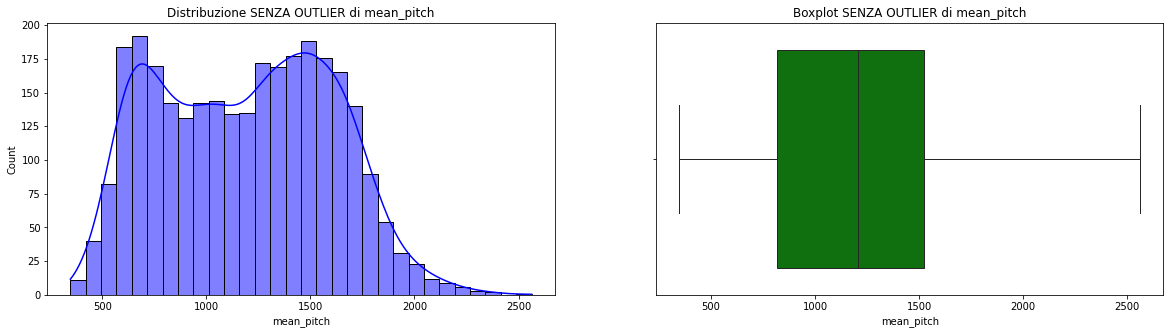

For Feature mean_pitch, the following were removed: 1 samples


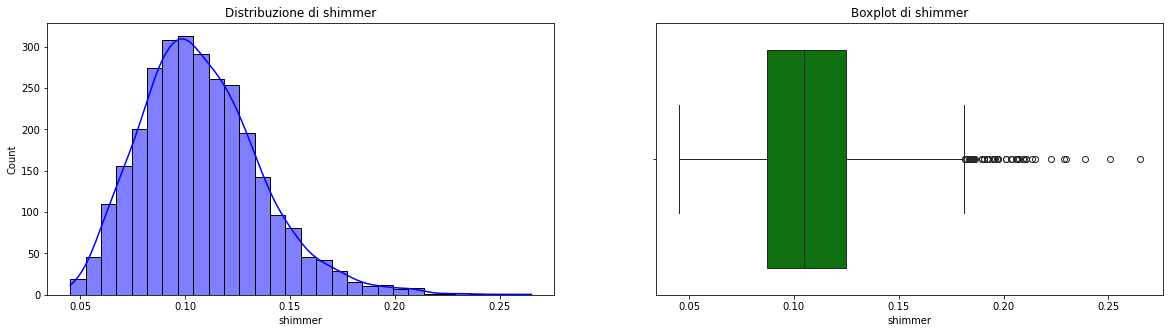

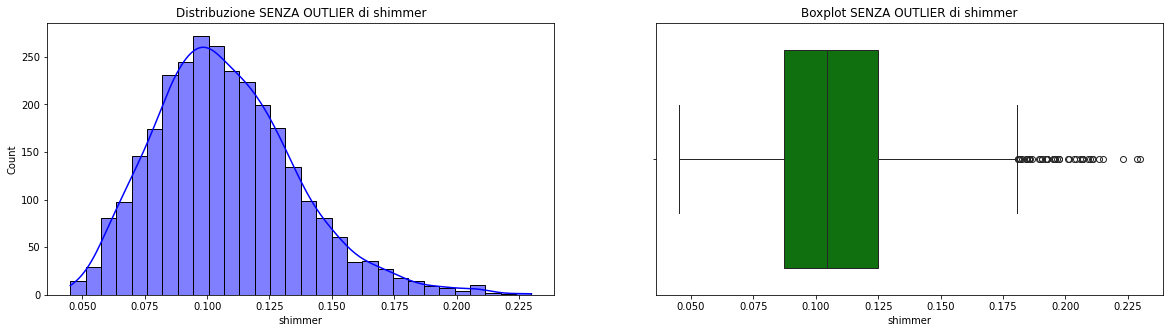

For Feature shimmer, the following were removed: 3 samples


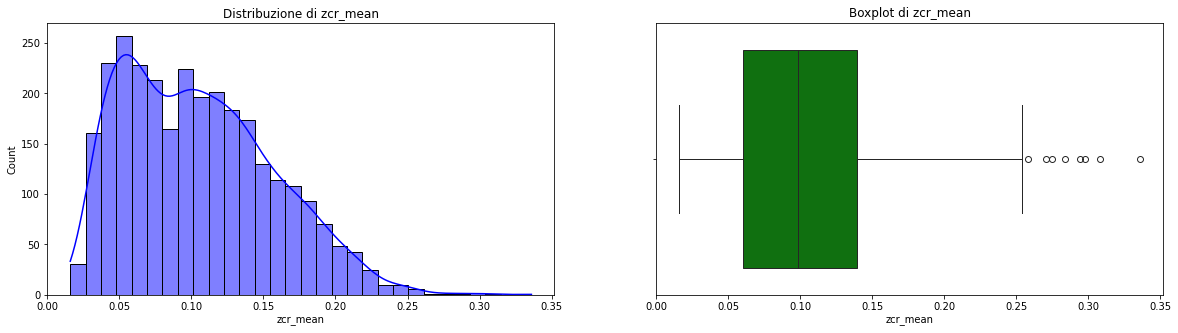

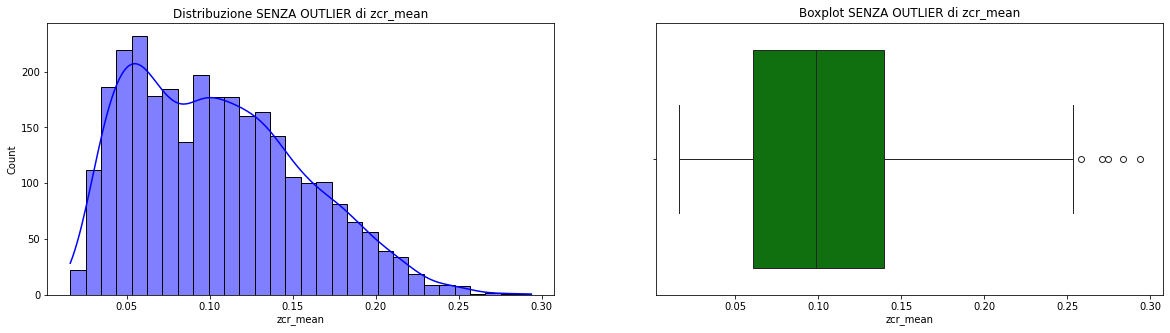

For Feature zcr_mean, the following were removed: 3 samples


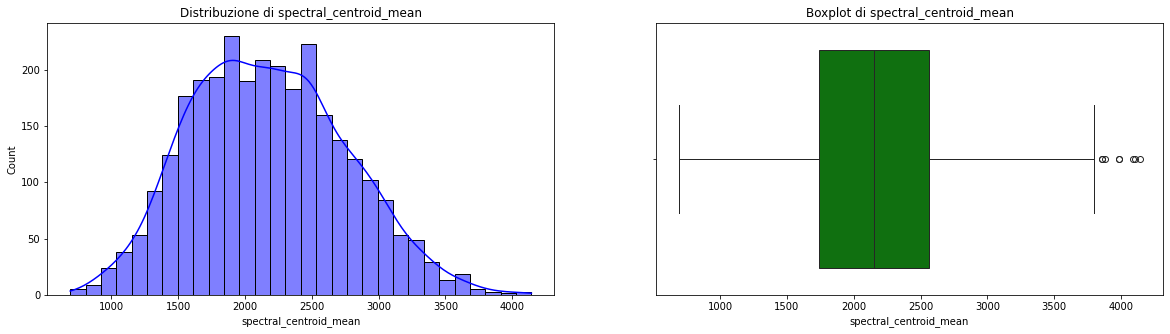

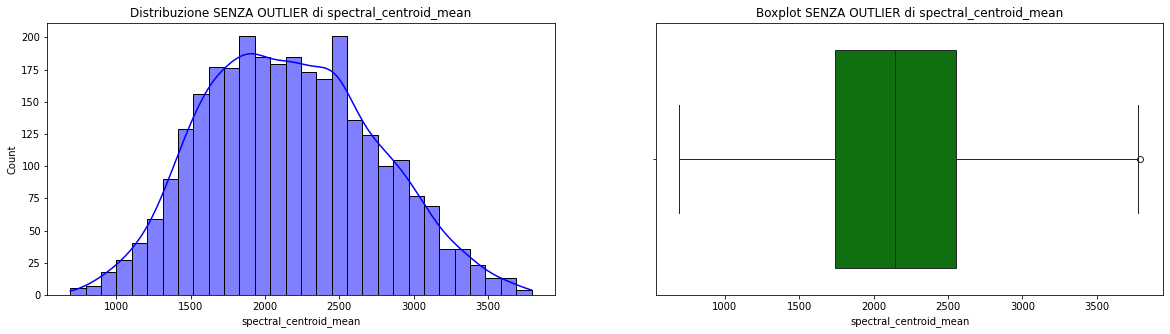

For Feature spectral_centroid_mean, the following were removed: 7 samples


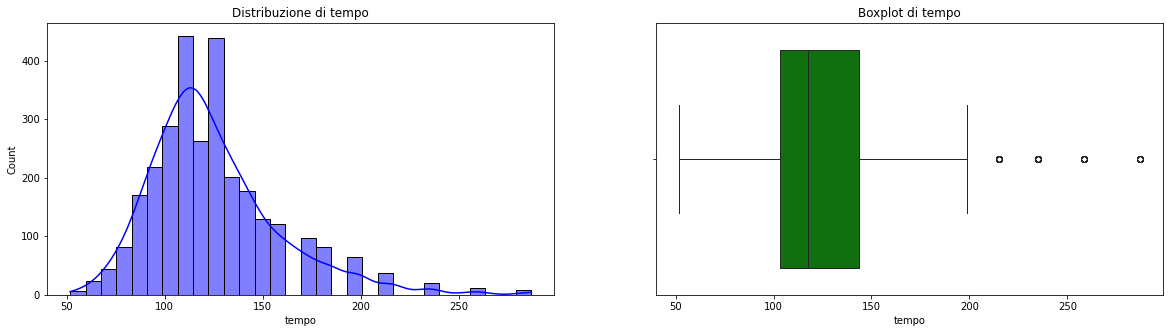

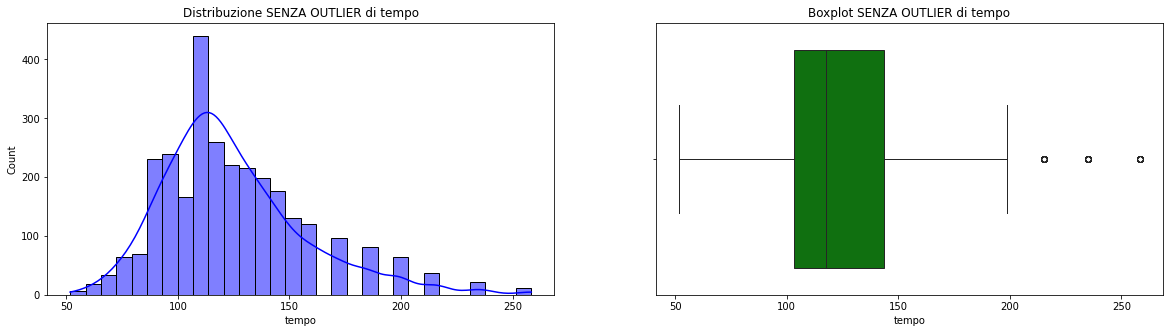

For Feature tempo, the following were removed: 9 samples
Total outliers removed: 23


In [183]:
# 5a. REMOVING ELEMENTS OUTSIDE THE BOX PLOT
colonne_outlier_tanti=['jitter','shimmer','tempo']
colonne_outlier=['mean_pitch','jitter','shimmer','zcr_mean','spectral_centroid_mean','tempo']
colonne_outlier=['mean_pitch','shimmer','zcr_mean','spectral_centroid_mean','tempo'] 
df_filtered=df_dev.copy()
for col in colonne_outlier:
    Q1 = df_filtered[col].quantile(0.25)
    Q3 = df_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    if col == 'zcr_mean':
        upper_bound = Q3 + 2 * IQR
    if col == 'shimmer' or col == 'tempo':
        upper_bound = Q3 + 3 * IQR
    if col == 'jitter':
        lower_bound = Q1 - 5 * IQR
        upper_bound = Q3 + 5 * IQR

    prima=len(df_filtered)
    df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]
    dopo=len(df_filtered)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.histplot(df_dev[col], kde=True, bins=30, color='blue', ax=axes[0])
    axes[0].set_title(f"Distribuzione di {col}")
    
    sns.boxplot(x=df_dev[col], color='green', ax=axes[1])
    axes[1].set_title(f"Boxplot di {col}")
    plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.histplot(df_filtered[col], kde=True, bins=30, color='blue', ax=axes[0])
    axes[0].set_title(f"Distribuzione SENZA OUTLIER di {col}")

    sns.boxplot(x=df_filtered[col], color='green', ax=axes[1])
    axes[1].set_title(f"Boxplot SENZA OUTLIER di {col}")

    plt.show()
    
    print(f"For Feature {col}, the following were removed: {prima-dopo} samples")
print(f'Total outliers removed: {len(df_dev)-len(df_filtered)}')

df_senza_outlier = pd.concat([df_filtered, df_eval], sort=False)

0.25     1.00
0.50     7.50
0.75    20.00
0.95    41.00
0.99    56.75
Name: num_pauses, dtype: float64


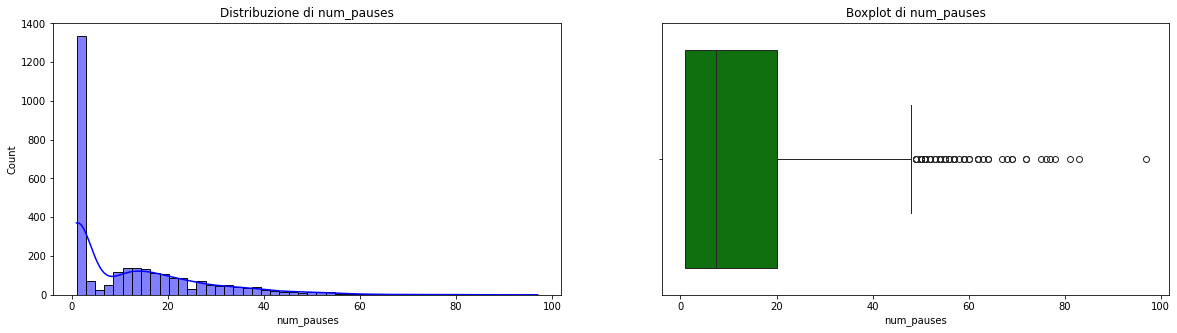

0.25     1.729172
0.50    17.333696
0.75    21.362358
0.95    28.926259
0.99    37.772880
Name: silence_duration, dtype: float64


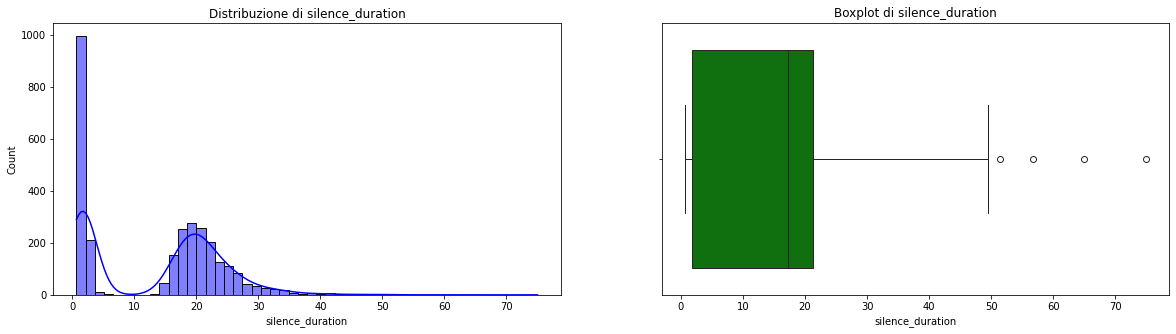

0.25     14.0
0.50    281.0
0.75    281.0
0.95    281.0
0.99    281.0
Name: num_characters, dtype: float64


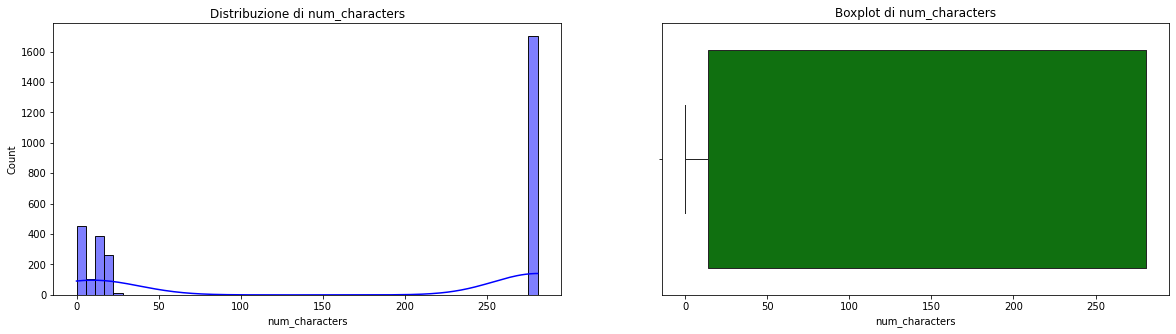

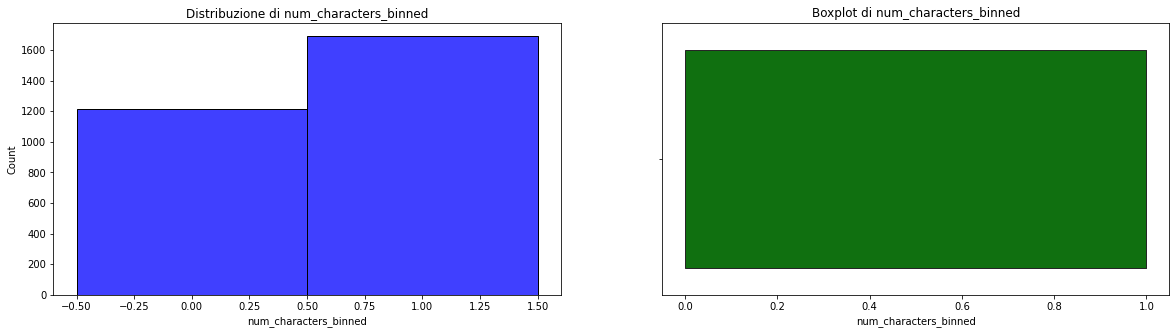

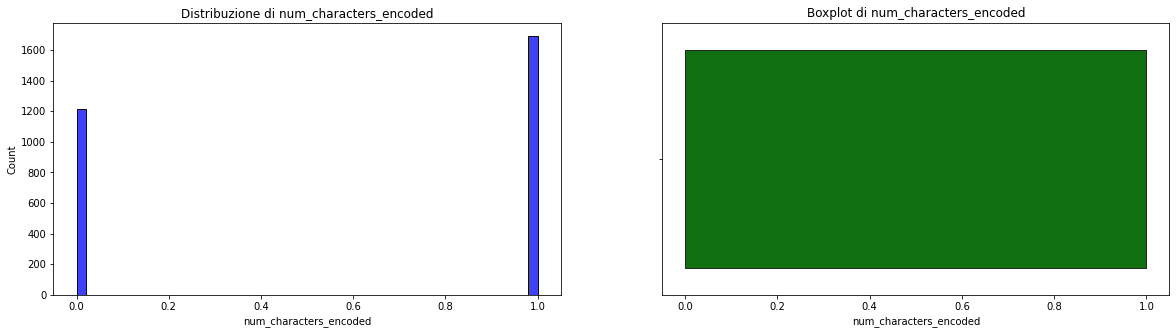

In [184]:
# 5b. DISCRETITION OF FEATURES AND DELETE (eventually) THE CODES
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_dev_bin=df_filtered.copy() 

# df_dev_bin.loc[:, 'num_pauses_binned'] = pd.cut(df_dev_bin.loc[:, 'num_pauses'], bins=[0, 2, 20, 40, np.inf], labels=[0, 1, 2, 3])
# df_dev_bin.loc[:,'silence_duration_binned'] = pd.cut(df_dev_bin.loc[:,'silence_duration'], bins=[-np.inf, 10, 25, np.inf], labels=[0, 1, 2])
df_dev_bin.loc[:, 'num_characters_binned'] = pd.cut(df_dev_bin.loc[:,'num_characters'], bins=[-np.inf, 50, np.inf], labels=[0, 1])

colonne_zero_neg=['num_pauses','silence_duration','num_characters']
colonne_zero_neg_bin=['num_characters']
for col in colonne_zero_neg:
    conteggi = df_dev_bin[col].astype(int).value_counts()
    print(df_dev[col].quantile([0.25, 0.5, 0.75, 0.95, 0.99]))
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    sns.histplot(df_dev[col], kde=True, bins=50, color='blue', ax=axes[0])
    axes[0].set_title(f"Distribuzione di {col}")

    sns.boxplot(x=df_dev[col], color='green', ax=axes[1])
    axes[1].set_title(f"Boxplot di {col}")
    plt.show()
    if col not in colonne_zero_neg_bin:
        continue
    plt.show()
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    sns.histplot(df_dev_bin[f'{col}_binned'], bins=50, color='blue', ax=axes[0])
    axes[0].set_title(f"Distribuzione di {col}_binned")

    sns.boxplot(x=df_dev_bin[f'{col}_binned'], color='green', ax=axes[1])
    axes[1].set_title(f"Boxplot di {col}_binned")
    plt.show()
    
    df_dev_bin= df_dev_bin.drop(columns=[col])
    
    
    df_dev_bin[f'{col}_encoded'] = le.fit_transform(df_dev_bin[f'{col}_binned'])
    df_dev_bin= df_dev_bin.drop(columns=[f'{col}_binned'])
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    sns.histplot(df_dev_bin[f'{col}_encoded'], bins=50, color='blue', ax=axes[0])
    axes[0].set_title(f"Distribuzione di {col}_encoded")
 
    sns.boxplot(x=df_dev_bin[f'{col}_encoded'], color='green', ax=axes[1])
    axes[1].set_title(f"Boxplot di {col}_encoded")
    plt.show()

    
df_eval_bin=df_eval.copy()
# df_eval_bin.loc[:, 'num_pauses_binned'] = pd.cut(df_eval_bin.loc[:, 'num_pauses'], bins=[0, 2, 20, 40, np.inf], labels=[0, 1, 2, 3])
# df_eval_bin.loc[:,'silence_duration_binned'] = pd.cut(df_eval_bin.loc[:,'silence_duration'], bins=[-np.inf, 10, 25, np.inf], labels=[0, 1, 2])
df_eval_bin.loc[:, 'num_characters_binned'] = pd.cut(df_eval_bin.loc[:,'num_characters'], bins=[-np.inf, 50, np.inf], labels=[0, 1])
for col in colonne_zero_neg_bin:
    df_eval_bin[f'{col}_encoded'] = le.fit_transform(df_eval_bin[f'{col}_binned'])
    df_eval_bin= df_eval_bin.drop(columns=[f'{col}_binned'])
    df_eval_bin= df_eval_bin.drop(columns=[col])

df_bin = pd.concat([df_dev_bin, df_eval_bin], sort=False)



They were removed 5 outliers


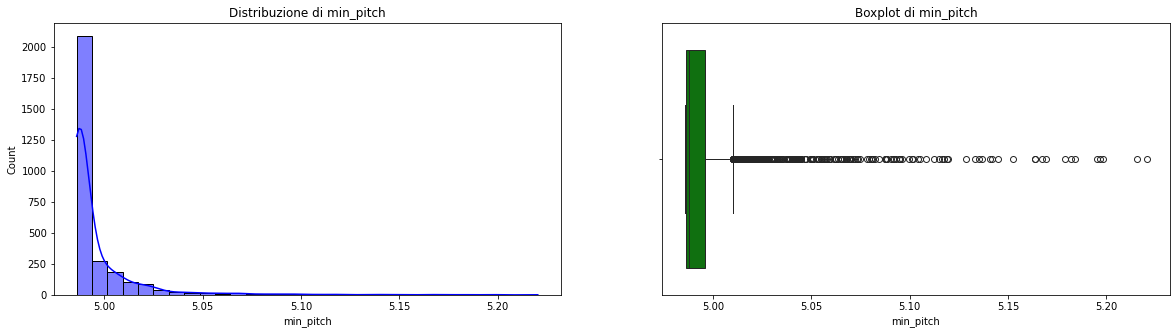

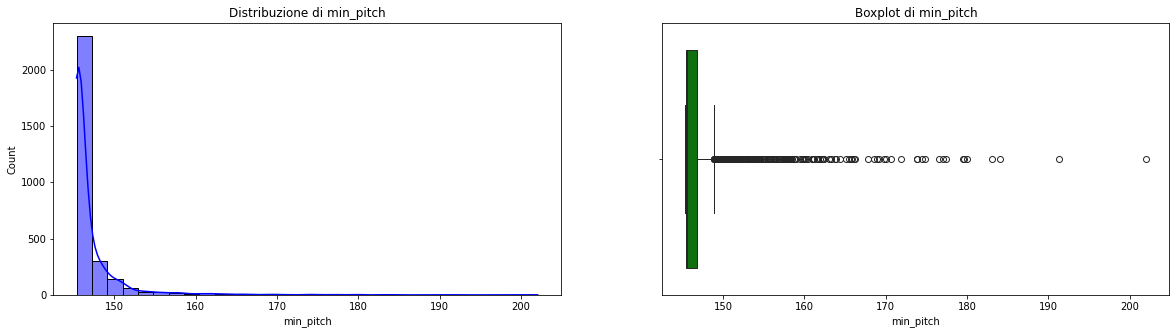

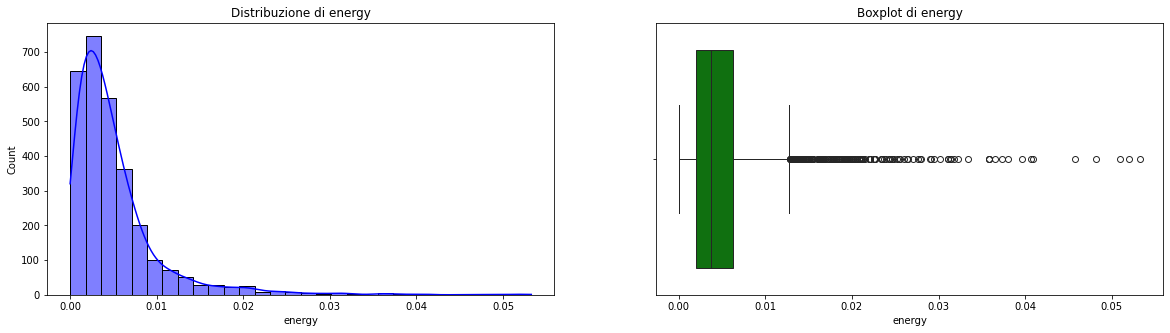

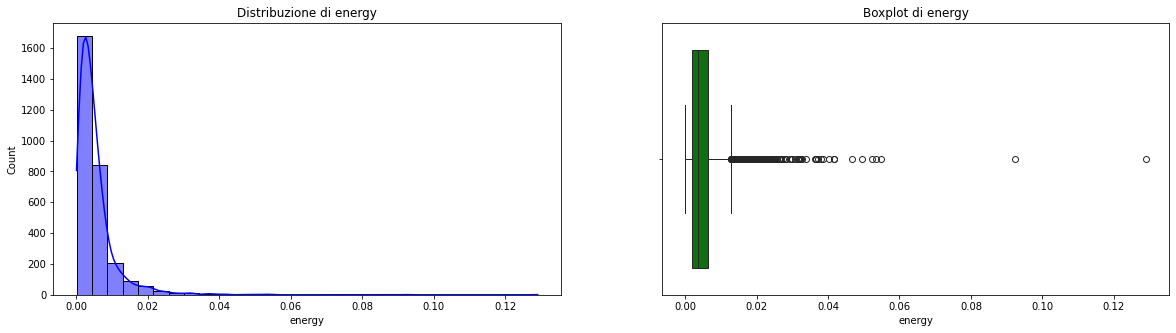

In [185]:
# 5c. Trasformations
from sklearn.preprocessing import StandardScaler

altre_colonne=['max_pitch','min_pitch','energy']
altre_colonne=['min_pitch','energy']

df_dev_new=df_dev_bin.copy()
df_dev_new = df_dev_new[df_dev_new['energy'] <= 0.06]
df_dev_new = df_dev_new[df_dev_new['min_pitch'] <= 190]
df_dev_new = df_dev_new[df_dev_new['max_pitch'] > 1000]
df_dev_new_senzalog=df_dev_new.copy()
print(f'They were removed {len(df_dev_bin)-len(df_dev_new)} outliers')

for col in altre_colonne:
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    df_dev_new[col] = np.log1p(df_dev_new[col])

    sns.histplot(df_dev_new[col], kde=True, bins=30, color='blue', ax=axes[0])
    axes[0].set_title(f"Distribuzione di {col}")
    
    sns.boxplot(x=df_dev_new[col], color='green', ax=axes[1])
    axes[1].set_title(f"Boxplot di {col}")
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    
    sns.histplot(df_dev[col], kde=True, bins=30, color='blue', ax=axes[0])
    axes[0].set_title(f"Distribuzione di {col}")

    sns.boxplot(x=df_dev[col], color='green', ax=axes[1])
    axes[1].set_title(f"Boxplot di {col}")
    plt.show()


df_eval_new=df_eval_bin.copy()
df_new_senzalog = pd.concat([df_dev_new_senzalog, df_eval_new], sort=False)
for col in altre_colonne:
    df_eval_new[col] = np.log1p(df_eval_new[col])
    
df_new = pd.concat([df_dev_new, df_eval_new], sort=False)


In [186]:
df_prima_di_rimuovere_outlier_copia=df_encoding.copy()
df_prima_di_rimuovere_outlier_copia=df_prima_di_rimuovere_outlier_copia.drop(columns=['path'])
print('SENZA LA GESTIONE DEGLI OUTLIER')
print('\n Modello semplice k fold: ')
reg=modello_semplice_kfold(df_prima_di_rimuovere_outlier_copia)
print('\n Modello semplice k fold e log: ')
modello_semplice_kfold_log(df_prima_di_rimuovere_outlier_copia)
print('\n Modello migliore k fold: ')
reg,y_valid_lista,y_pred_lista=modello_migliore_kfold(df_prima_di_rimuovere_outlier_copia)
print('\n Modello migliore k fold stratificato: ')
modello_migliore_kfold_stratified(df_prima_di_rimuovere_outlier_copia)

df_new_copia=df_new.copy()
df_new_copia=df_new_copia.drop(columns=['path'])
print('GESTIONE OUTLIER')
print('\n Modello semplice k fold: ')
reg=modello_semplice_kfold(df_new_copia)
print('\n Modello semplice k fold e log: ')
modello_semplice_kfold_log(df_new_copia)
print('\n Modello migliore k fold: ')
reg,y_valid_lista,y_pred_lista=modello_migliore_kfold(df_new_copia)
print('\n Modello migliore k fold stratificato: ')
modello_migliore_kfold_stratified(df_new_copia)
print()

df_new_copia=df_new_senzalog.copy()
df_new_copia=df_new_copia.drop(columns=['path'])
print('GESTIONE OUTLIER  MA SENZA TRASFORMAZIONI')
print('\n Modello semplice k fold: ')
reg=modello_semplice_kfold(df_new_copia)
print('\n Modello semplice k fold e log: ')
modello_semplice_kfold_log(df_new_copia)
print('\n Modello migliore k fold: ')
reg,y_valid_lista,y_pred_lista=modello_migliore_kfold(df_new_copia)
print('\n Modello migliore k fold stratificato: ')
modello_migliore_kfold_stratified(df_new_copia)
print()

SENZA LA GESTIONE DEGLI OUTLIER

 Modello semplice k fold: 
Fold 1: r2_score = 0.3719, RMSE = 9.5914
Fold 2: r2_score = 0.3818, RMSE = 11.0465
Fold 3: r2_score = 0.3173, RMSE = 10.5988
Fold 4: r2_score = 0.3653, RMSE = 9.8347
Fold 5: r2_score = 0.3835, RMSE = 10.0121

Mean r2_score: 0.3640
Mean RMSE: 10.2167

 Modello semplice k fold e log: 
Fold 1: r2_score = 0.3992, RMSE = 9.3809
Fold 2: r2_score = 0.3626, RMSE = 11.2162
Fold 3: r2_score = 0.3242, RMSE = 10.5447
Fold 4: r2_score = 0.3843, RMSE = 9.6861
Fold 5: r2_score = 0.3896, RMSE = 9.9626

Mean r2_score: 0.3720
Mean RMSE: 10.1581

 Modello migliore k fold: 
Fold 1: r2_score = 0.3902, RMSE = 9.4511
Fold 2: r2_score = 0.3860, RMSE = 11.0084
Fold 3: r2_score = 0.3331, RMSE = 10.4754
Fold 4: r2_score = 0.4078, RMSE = 9.4994
Fold 5: r2_score = 0.4204, RMSE = 9.7081

Mean r2_score: 0.3875
Mean RMSE: 10.0285

 Modello migliore k fold stratificato: 
Fold 1: r2_score = 0.3541, RMSE = 10.2223
Fold 2: r2_score = 0.4431, RMSE = 9.5866
Fold 3

In [187]:
df_new_copia=df_senza_outlier.copy()
df_new_copia=df_new_copia.drop(columns=['path'])
print('SENZA BIN E LOG')
print('\n Modello semplice k fold: ')
reg=modello_semplice_kfold(df_new_copia)
print('\n Modello semplice k fold e log: ')
modello_semplice_kfold_log(df_new_copia)
print('\n Modello migliore k fold: ')
reg,y_valid_lista,y_pred_lista=modello_migliore_kfold(df_new_copia)
print('\n Modello migliore k fold stratificato: ')
modello_migliore_kfold_stratified(df_new_copia)
print()

SENZA BIN E LOG

 Modello semplice k fold: 
Fold 1: r2_score = 0.3699, RMSE = 9.7989
Fold 2: r2_score = 0.3637, RMSE = 10.6183
Fold 3: r2_score = 0.3823, RMSE = 10.4431
Fold 4: r2_score = 0.3845, RMSE = 10.2175
Fold 5: r2_score = 0.3246, RMSE = 10.0844

Mean r2_score: 0.3650
Mean RMSE: 10.2324

 Modello semplice k fold e log: 
Fold 1: r2_score = 0.3829, RMSE = 9.6976
Fold 2: r2_score = 0.3573, RMSE = 10.6711
Fold 3: r2_score = 0.3654, RMSE = 10.5845
Fold 4: r2_score = 0.3696, RMSE = 10.3406
Fold 5: r2_score = 0.3600, RMSE = 9.8170

Mean r2_score: 0.3670
Mean RMSE: 10.2222

 Modello migliore k fold: 
Fold 1: r2_score = 0.3942, RMSE = 9.6083
Fold 2: r2_score = 0.3626, RMSE = 10.6273
Fold 3: r2_score = 0.4066, RMSE = 10.2355
Fold 4: r2_score = 0.3949, RMSE = 10.1305
Fold 5: r2_score = 0.3583, RMSE = 9.8298

Mean r2_score: 0.3833
Mean RMSE: 10.0863

 Modello migliore k fold stratificato: 
Fold 1: r2_score = 0.4451, RMSE = 9.5813
Fold 2: r2_score = 0.3445, RMSE = 10.4646
Fold 3: r2_score = 

After training the regression model on the dataset without these outlier samples, we observed an increase in RMSE.

One possible explanation for this outcome is the reduction in the number of training samples. By removing outliers, we inadvertently decreased the amount of available data, which can negatively impact the model’s ability to generalize. Additionally, the initial dataset was already limited in size, so any further reduction in data makes the issue worse.

Furthermore, extreme values are not necessarily errors but rather valid data points that reflect natural variations in the population. If these points carry meaningful information, their removal can weaken the model’s ability to capture certain relationships, leading to poorer performance. 

For these reasons, we have decided to proceed with our analysis without removing the outliers we identified related to the features.

### Feature extraction

For the age estimation task, a variety of speech-related features were extracted to capture both the spectral and temporal characteristics of the speaker's voice. These features include statistical information derived from the spectrogram, Mel-Frequency Cepstral Coefficients (MFCCs), as well as the first and second derivatives of MFCCs (delta and delta-delta coefficients). Additional spectral features, such as spectral rolloff and spectral flatness, were also extracted to provide insights into the distribution of frequency components within the speech signal.
In addition to these spectral features, rhythm-related features were extracted from the tempogram, which reflects the periodicity and rhythm of the speech.

Together, these features provide a rich, multi-dimensional representation of the speech signal, capturing both static and dynamic characteristics that are potentially indicative of a speaker’s age.


In [188]:
import librosa.display
import IPython.display as ipd
from tqdm.notebook import tqdm

In [190]:
df=df_encoding
audio_data=load_audio_files(df)

In [ ]:
# Spectogram

def get_spectrogram_feature_names(n_mels=40):
    # Static MFCCs
    spectrogram_means = [f'spectrogram_mean_{i+1}' for i in range(n_mels)]
    spectrogram_std = [f'spectrogram_std_{i+1}' for i in range(n_mels)]
    # Combine all names
    feature_names = (spectrogram_means + spectrogram_std)
    return feature_names

def extract_spectrogram_features(audio_data):
    features_list = []
    for audio_key in audio_data.keys():
        y, sr = audio_data[audio_key]
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # Extract statistical features
        features = np.concatenate([
            np.mean(log_spectrogram, axis=1),  # Mean across time
            np.std(log_spectrogram, axis=1),  # Standard deviation across time
        ])
        features_list.append(features)
   
    spectr_features = np.array(features_list)
    spectr_feature_names = get_spectrogram_feature_names(n_mels=40)
    df_spectrogram = pd.DataFrame(spectr_features, columns=spectr_feature_names)
    
    return df_spectrogram

df_spectrogram = extract_spectrogram_features(audio_data)
df_spectrogram.head()

In [ ]:
# MFCC

def get_mfcc_feature_names(n_mfcc):
    # Static MFCCs
    mfcc_mean_names = [f'mfcc_mean_{i+1}' for i in range(n_mfcc)]
    mfcc_std_names = [f'mfcc_std_{i+1}' for i in range(n_mfcc)]

    # Delta MFCCs
    delta_mean_names = [f'delta_mfcc_mean_{i+1}' for i in range(n_mfcc)]
    delta_std_names = [f'delta_mfcc_std_{i+1}' for i in range(n_mfcc)]

    # Delta-Delta MFCCs
    delta_delta_mean_names = [f'delta_delta_mfcc_mean_{i+1}' for i in range(n_mfcc)]
    delta_delta_std_names = [f'delta_delta_mfcc_std_{i+1}' for i in range(n_mfcc)]

    # Combine all names
    feature_names = (
        mfcc_mean_names + mfcc_std_names +
        delta_mean_names + delta_std_names +
        delta_delta_mean_names + delta_delta_std_names
    )
    return feature_names

def extract_mfcc_features(audio_data, n_mfcc):
    
    features_list = []
    for audio_key in audio_data.keys():
        y, sr = audio_data[audio_key]
        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
        # Compute Delta and Delta-Delta
        # For speech emotion or age estimation, temporal features like deltas often improve performance.
        delta = librosa.feature.delta(mfcc)
        delta_delta = librosa.feature.delta(mfcc, order=2)
    
        # Concatenate static, delta, and delta-delta
        combined = np.vstack([mfcc, delta, delta_delta])
    
        # Compute summary statistics
        features = np.concatenate([
            np.mean(combined, axis=1),  # Mean of each coefficient
            np.std(combined, axis=1),  # Standard deviation
        ])

        features_list.append(features)
    
   
    mfcc_features = np.array(features_list)
    mfcc_feature_names = get_mfcc_feature_names(n_mfcc)
    df_mfcc = pd.DataFrame(mfcc_features, columns=mfcc_feature_names)
    
    return df_mfcc

df_mfcc_13 = extract_mfcc_features(audio_data, 13)
df_mfcc_13.head()

In [ ]:
# Spectral features

def get_spectral_feature_names():
    feature_names = (
        [f'chroma_stft_mean_{i+1}' for i in range(12)] +  # 12 features
        ['rms_mean'] +                                    # 1 feature
        ['spectral_bandwidth_mean'] +                     # 1 feature
        [f'spectral_contrast_mean_{i+1}' for i in range(7)] +  # 7 features
        ['spectral_flatness_mean'] +                      # 1 feature
        ['spectral_rolloff_mean'] +                       # 1 feature
        [f'polyfeature_mean_{i+1}' for i in range(2)]     # 2 features
    )
    return feature_names

def extract_spectral_features(audio_data, sr=22050):
    
    features_list = []
    for audio_key in audio_data.keys():
        y, sr = audio_data[audio_key]

        # 1. Chroma Features
        n_fft = 512 # in speech processing, the recommended value is 512
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=512)   #12 features


        # 2. Energy and Spectral Features
        rms = librosa.feature.rms(y=y, frame_length=n_fft)   #1 feature
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=512) #1 feature
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=512)   #7 features
        spectral_flatness = librosa.feature.spectral_flatness(y=y, n_fft=512)          #1 feature
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=512)     #1 feature

        # 3. Other Features
        polyfeature = librosa.feature.poly_features(y=y, sr=sr, n_fft=512)             #2 features
    

        # Only calculate averages for each feature
        features = np.concatenate([
            np.mean(chroma_stft, axis=1), 
            np.mean(rms, axis=1),
            np.mean(spectral_bandwidth, axis=1),
            np.mean(spectral_contrast, axis=1),
            np.mean(spectral_flatness, axis=1),
            np.mean(spectral_rolloff, axis=1),
            np.mean(polyfeature, axis=1),
        ])



        features_list.append(features)
    
   
    spectral_features = np.array(features_list)
    spectral_feature_names = get_spectral_feature_names()
    df_spectral = pd.DataFrame(spectral_features, columns=spectral_feature_names)
    
    return df_spectral

df_spectral = extract_spectral_features(audio_data)
df_spectral.head()


In [ ]:
# Rhythm features

def get_tempo_feature_names():
    # Tempogram Mean (13 features)
    tempogram_mean_names = [f'tempogram_mean_{i+1}' for i in range(13)]
    
    # Tempogram Std (13 features)
    tempogram_std_names = [f'tempogram_std_{i+1}' for i in range(13)]
    
    # Tempogram Ratio Mean (13 features)
    tempogram_ratio_mean_names = [f'tempogram_ratio_mean_{i+1}' for i in range(13)]
    
    # Combine all feature names
    feature_names = tempogram_mean_names + tempogram_std_names + tempogram_ratio_mean_names
    return feature_names

def extract_tempo_features(audio_data, sr=22050):
    
    features_list = []
    for audio_key in audio_data.keys():
        y, sr = audio_data[audio_key]
        
        # Calculate the onset envelope
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)

        # 1. Tempo (Beats per minute)
        #tempo = librosa.feature.tempo(y=y, sr=sr, onset_envelope=onset_env)  già nel dataset

        # 2. Tempogram (Autocorrelation of the onset strength envelope)
        tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
        # Focus on the first 13 frequency bins of the tempogram
        tempogram = tempogram[:13, :]  # Slice to keep only the first 13 bins
        # It is common to focus only on the first N rows (e.g 13) of the matrix
        # prioritize the low-frequency bins (e.g., the first 20-30 frequency bins) for global rhythmic information

        # 4. Tempogram Ratio Features
        tempogram_ratio = librosa.feature.tempogram_ratio(onset_envelope=onset_env, sr=sr) # 13 (vedi documentazione)

        # Extract mean and standard deviation for all tempogram-based features
        tempogram_mean = np.mean(tempogram, axis=1)
        tempogram_std = np.std(tempogram, axis=1)

        tempogram_ratio_mean = np.mean(tempogram_ratio, axis=1) 
        #tempogram_ratio_std = np.std(tempogram_ratio, axis=1)   per non appesantire

        # Combine all features into a single feature vector
        features = np.concatenate([ 
            tempogram_mean,
            tempogram_std,
            tempogram_ratio_mean,
            #tempogram_ratio_std,
        ])

        features_list.append(features)
   
    tempo_features = np.array(features_list)
    tempo_feature_names = get_tempo_feature_names()
    df_tempo = pd.DataFrame(tempo_features, columns=tempo_feature_names)
    
    return df_tempo

df_tempo = extract_tempo_features(audio_data)
df_tempo = df_tempo.drop(columns = ['tempogram_mean_1', 'tempogram_std_1']) #tutti 1 e 0
df_tempo.head()  

In [ ]:
print(df_spectrogram.shape)
print(df_mfcc_13.shape)
print(df_spectral.shape)
print(df_tempo.shape)
print(df.shape)

In [ ]:
# Concatenate all the datasets
df_reset_index=df.copy()
df_reset_index = df_reset_index.reset_index(drop=True)
dataset_completo = pd.concat([df_reset_index, df_spectrogram , df_mfcc_13, df_spectral, df_tempo], axis=1)
print(dataset_completo.shape) #51 + 80 + 78 + 25 + 37 + (1) = 272
dataset_completo


In [ ]:
# Saving in CSV format
csv_file = "dataset_completo_senza_rimozione_outlier.csv"
dataset_completo.to_csv(csv_file,index=False)

### Feature Selection and Model Optimization

Our observations revealed that the best-performing approach was achieved by initially including all extracted and original features, then selecting the top 40 most relevant ones.

To achieve this, we applied a structured feature selection strategy. First, we trained a basic model on the complete dataset, which included all available features. After training, we analyzed the feature importance scores provided by the model to identify the most meaningful attributes. This step was crucial as it allowed us to retain only the features that contributed the most to the predictions, while discarding less relevant ones.

Reducing the dimensionality of the dataset in this way helped to preserve the most informative features while eliminating those that introduced redundancy or noise. By doing so, we obtained a smaller yet more effective dataset, which not only improved computational efficiency but also enhanced model generalization. In addition, we observed that retraining the model using only the most informative features resulted in a significant improvement in performance. With this refined feature set, we proceeded with hyperparameter optimization, ensuring that the model was fine-tuned using only the most valuable features for the task.

In [191]:
df_completo=pd.read_csv("dataset_completo_senza_rimozione_outlier.csv")
dataset_completo=df_completo.copy()
dataset_completo=dataset_completo.drop(columns=['path'])
dataset_completo

age  mean_pitch  max_pitch  min_pitch    jitter   shimmer    energy  \
0     24.0  1821.69060  3999.7170  145.43066  0.013795  0.082725  0.002254   
1     22.5  1297.81870  3998.8590  145.37268  0.025349  0.096242  0.007819   
2     22.0  1332.85240  3998.8025  145.42395  0.019067  0.119456  0.002974   
3     22.0  1430.34990  3998.4510  147.98083  0.017004  0.102389  0.022371   
4     22.0  1688.72340  3998.6113  145.44772  0.028027  0.124831  0.005369   
...    ...         ...        ...        ...       ...       ...       ...   
3612   NaN   570.62740  3900.6730  145.67577  0.018842  0.079197  0.004545   
3613   NaN   974.13965  3919.0024  145.90408  0.024367  0.117492  0.000878   
3614   NaN  1113.27650  3999.3510  145.38307  0.020637  0.089355  0.009148   
3615   NaN  1759.17420  3999.4610  145.56773  0.026118  0.106429  0.003707   
3616   NaN   779.53890  3972.4630  147.44424  0.010952  0.108114  0.003370   

      zcr_mean  spectral_centroid_mean       tempo  ...  \
0     0.210093             3112.257251  151.999081  ...   
1     0.078849             1688.016389  129.199219  ...   
2     0.105365             2576.901706  117.453835  ...   
3     0.173701             3269.751413  117.453835  ...   
4     0.107279             1930.897375  112.347147  ...   
...        ...                     ...         ...  ...   
3612  0.072083             1946.502158  112.347147  ...   
3613  0.076900             3319.620800  112.347147  ...   
3614  0.095613             1973.127197  112.347147  ...   
3615  0.141474             2137.517812  117.453835  ...   
3616  0.083540             2530.285199  184.570312  ...   

      tempogram_ratio_mean_4  tempogram_ratio_mean_5  tempogram_ratio_mean_6  \
0                   0.430239                0.411506                0.410611   
1                   0.522779                0.494058                0.502814   
2                   0.565462                0.478635                0.469233   
3                   0.495782                0.412305                0.436536   
4                   0.465711                0.443485                0.461332   
...                      ...                     ...                     ...   
3612                0.381724                0.334344                0.323126   
3613                0.429927                0.301051                0.348424   
3614                0.415389                0.392955                0.391561   
3615                0.546219                0.482685                0.512169   
3616                0.597128                0.531144                0.482604   

      tempogram_ratio_mean_7  tempogram_ratio_mean_8  tempogram_ratio_mean_9  \
0                   0.496876                0.386556                0.383569   
1                   0.567657                0.493068                0.482628   
2                   0.563140                0.488601                0.454591   
3                   0.518216                0.439942                0.399838   
4                   0.515302                0.434586                0.436385   
...                      ...                     ...                     ...   
3612                0.387021                0.236992                0.321749   
3613                0.450033                0.382174                0.278053   
3614                0.480988                0.361234                0.384665   
3615                0.558028                0.465800                0.470318   
3616                0.610181                0.451313                0.372861   

      tempogram_ratio_mean_10  tempogram_ratio_mean_11  \
0                    0.402659                 0.354317   
1                    0.459933                 0.413158   
2                    0.461816                 0.378858   
3                    0.413282                 0.361573   
4                    0.411434                 0.345184   
...                       ...                      ...   
3612                 0.223136    

In [192]:
# Evaluation of the new dataset
print('\n Modello migliore k fold: ')
reg1,y_valid1,y_pred1=modello_migliore_kfold(dataset_completo)
print('\n Modello migliore k fold stratificato: ')
reg2,y_valid2,y_pred2=modello_migliore_kfold_stratified(dataset_completo)



 Modello migliore k fold: 
Fold 1: r2_score = 0.4113, RMSE = 9.2859
Fold 2: r2_score = 0.3620, RMSE = 11.2218
Fold 3: r2_score = 0.4034, RMSE = 9.9074
Fold 4: r2_score = 0.4384, RMSE = 9.2509
Fold 5: r2_score = 0.4262, RMSE = 9.6593

Mean r2_score: 0.4083
Mean RMSE: 9.8651

 Modello migliore k fold stratificato: 
Fold 1: r2_score = 0.3625, RMSE = 10.1561
Fold 2: r2_score = 0.4297, RMSE = 9.7011
Fold 3: r2_score = 0.4188, RMSE = 9.8536
Fold 4: r2_score = 0.4268, RMSE = 9.7061
Fold 5: r2_score = 0.4164, RMSE = 9.8607

Mean r2_score: 0.4108
Mean RMSE: 9.8555


In [193]:
num_features=40
df_top_features40, top_features_40,feature_importances1 = top_features_df(dataset_completo, reg1, num_features) # Mean RMSE: 9.4662 con num_features=40
num_features=30
df_top_features30, top_features_30,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)
num_features=50
df_top_features50, top_features_50,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)
num_features=60
df_top_features60, top_features_60,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)

In [194]:
top_features30=top_features_30.copy().tolist()
top_features30.append('age')
df_ridotto_30=dataset_completo.loc[:, top_features30]

top_features40=top_features_40.copy().tolist()
top_features40.append('age')
df_ridotto_40=dataset_completo.loc[:, top_features40]

top_features50=top_features_50.copy().tolist()
top_features50.append('age')
df_ridotto_50=dataset_completo.loc[:, top_features50]

top_features60=top_features_60.copy().tolist()
top_features60.append('age')
df_ridotto_60=dataset_completo.loc[:, top_features60]




In [195]:
print('30')
reg_top30,y_valid30,y_pred30=modello_migliore_kfold(df_ridotto_30)
modello_migliore_kfold_stratified(df_ridotto_30)
print('40')
reg_top40,y_valid40,y_pred40=modello_migliore_kfold(df_ridotto_40)
modello_migliore_kfold_stratified(df_ridotto_40)
print('50')
reg_top50,y_valid50,y_pred50=modello_migliore_kfold(df_ridotto_50)
modello_migliore_kfold_stratified(df_ridotto_50)
print('60')
reg_top60,y_valid60,y_pred60=modello_migliore_kfold(df_ridotto_60)
modello_migliore_kfold_stratified(df_ridotto_60)

print()

30
Fold 1: r2_score = 0.4246, RMSE = 9.1801
Fold 2: r2_score = 0.4013, RMSE = 10.8707
Fold 3: r2_score = 0.4291, RMSE = 9.6922
Fold 4: r2_score = 0.4522, RMSE = 9.1364
Fold 5: r2_score = 0.4634, RMSE = 9.3410

Mean r2_score: 0.4341
Mean RMSE: 9.6441
Fold 1: r2_score = 0.4122, RMSE = 9.7521
Fold 2: r2_score = 0.4556, RMSE = 9.4784
Fold 3: r2_score = 0.4276, RMSE = 9.7787
Fold 4: r2_score = 0.4474, RMSE = 9.5298
Fold 5: r2_score = 0.4202, RMSE = 9.8282

Mean r2_score: 0.4326
Mean RMSE: 9.6735
40
Fold 1: r2_score = 0.4300, RMSE = 9.1368
Fold 2: r2_score = 0.3953, RMSE = 10.9249
Fold 3: r2_score = 0.4322, RMSE = 9.6661
Fold 4: r2_score = 0.4537, RMSE = 9.1234
Fold 5: r2_score = 0.4666, RMSE = 9.3133

Mean r2_score: 0.4356
Mean RMSE: 9.6329
Fold 1: r2_score = 0.4165, RMSE = 9.7163
Fold 2: r2_score = 0.4540, RMSE = 9.4927
Fold 3: r2_score = 0.4271, RMSE = 9.7832
Fold 4: r2_score = 0.4456, RMSE = 9.5450
Fold 5: r2_score = 0.4304, RMSE = 9.7419

Mean r2_score: 0.4347
Mean RMSE: 9.6558
50
Fold 

In [196]:
num_features=45
df_top_features45, top_features_45,feature_importances1 = top_features_df(dataset_completo, reg1, num_features) # Mean RMSE: 9.4662 con num_features=40
num_features=35
df_top_features35, top_features_35,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)

In [197]:
top_features35=top_features_35.copy().tolist()
top_features35.append('age')
df_ridotto_35=dataset_completo.loc[:, top_features35]

top_features45=top_features_45.copy().tolist()
top_features45.append('age')
df_ridotto_45=dataset_completo.loc[:, top_features45]

In [198]:
print('35')
reg_top35,y_valid35,y_pred35=modello_migliore_kfold(df_ridotto_35)
modello_migliore_kfold_stratified(df_ridotto_35)
print('45')
reg_top45,y_valid45,y_pred45=modello_migliore_kfold(df_ridotto_45)
modello_migliore_kfold_stratified(df_ridotto_45)
print()

35
Fold 1: r2_score = 0.4280, RMSE = 9.1532
Fold 2: r2_score = 0.4001, RMSE = 10.8821
Fold 3: r2_score = 0.4325, RMSE = 9.6633
Fold 4: r2_score = 0.4525, RMSE = 9.1338
Fold 5: r2_score = 0.4678, RMSE = 9.3030

Mean r2_score: 0.4362
Mean RMSE: 9.6271
Fold 1: r2_score = 0.4122, RMSE = 9.7520
Fold 2: r2_score = 0.4522, RMSE = 9.5079
Fold 3: r2_score = 0.4288, RMSE = 9.7689
Fold 4: r2_score = 0.4493, RMSE = 9.5136
Fold 5: r2_score = 0.4272, RMSE = 9.7693

Mean r2_score: 0.4339
Mean RMSE: 9.6623
45
Fold 1: r2_score = 0.4296, RMSE = 9.1401
Fold 2: r2_score = 0.3932, RMSE = 10.9439
Fold 3: r2_score = 0.4362, RMSE = 9.6320
Fold 4: r2_score = 0.4530, RMSE = 9.1292
Fold 5: r2_score = 0.4622, RMSE = 9.3512

Mean r2_score: 0.4349
Mean RMSE: 9.6393
Fold 1: r2_score = 0.4189, RMSE = 9.6964
Fold 2: r2_score = 0.4463, RMSE = 9.5589
Fold 3: r2_score = 0.4307, RMSE = 9.7523
Fold 4: r2_score = 0.4435, RMSE = 9.5635
Fold 5: r2_score = 0.4329, RMSE = 9.7204

Mean r2_score: 0.4345
Mean RMSE: 9.6583



Fold 1:


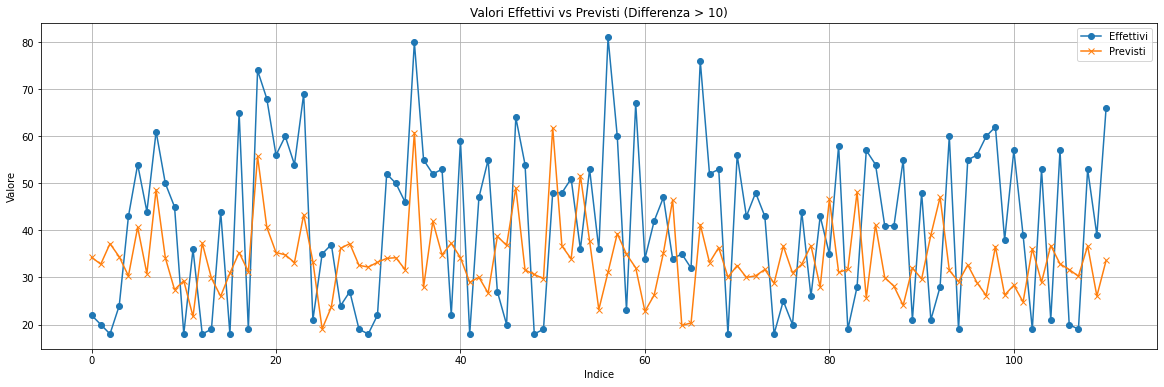

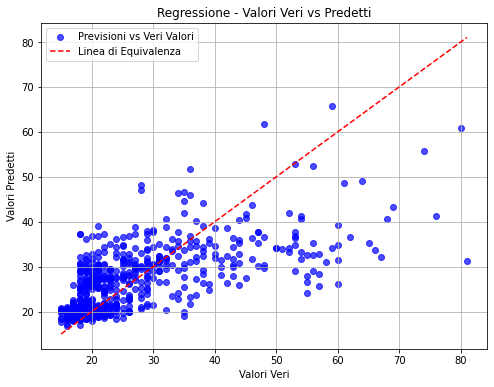

Fold 2:


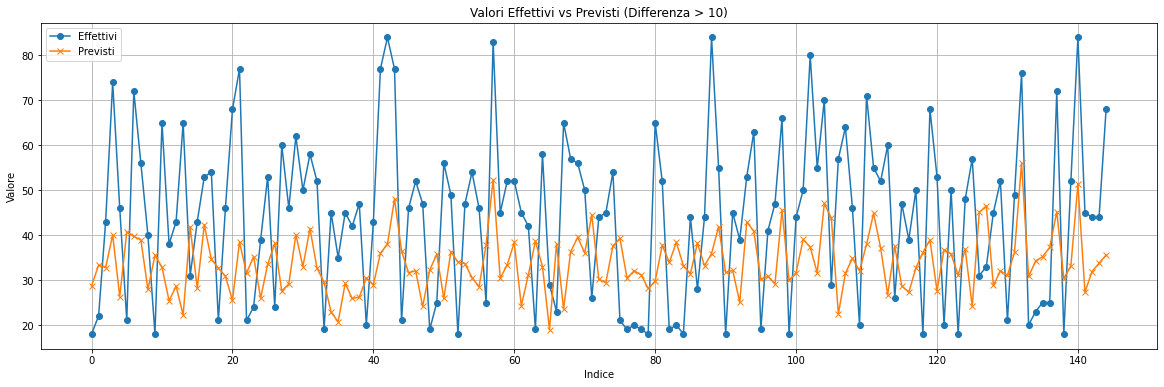

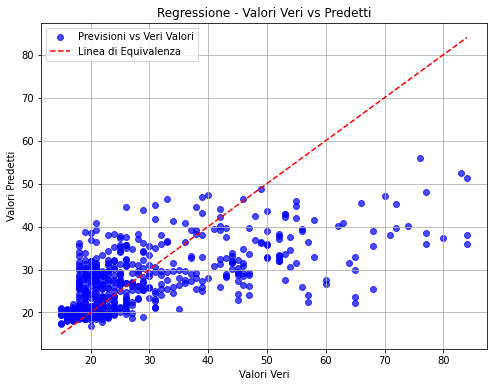

Fold 3:


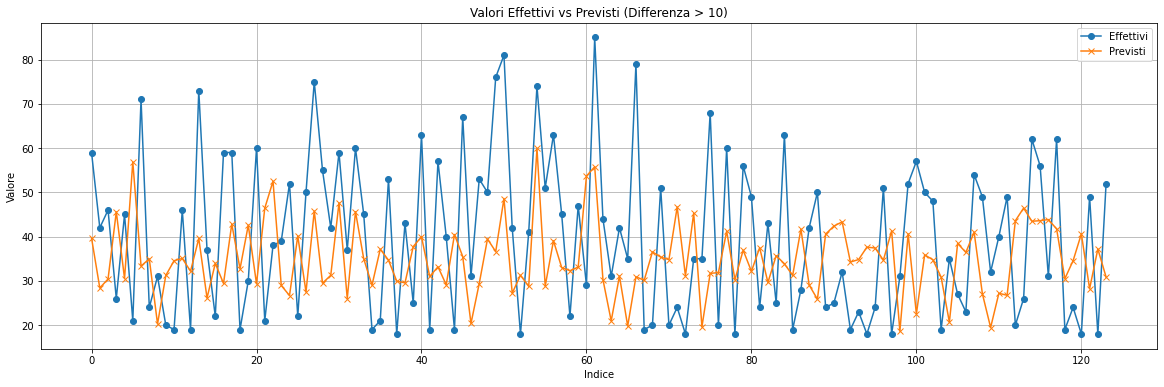

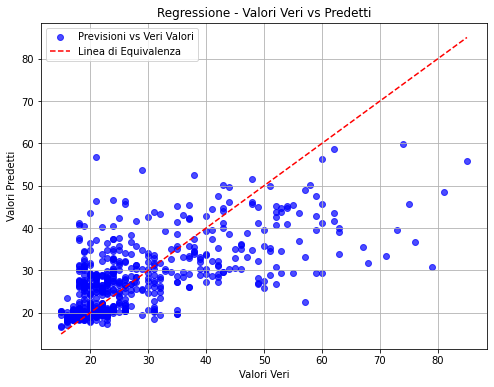

Fold 4:


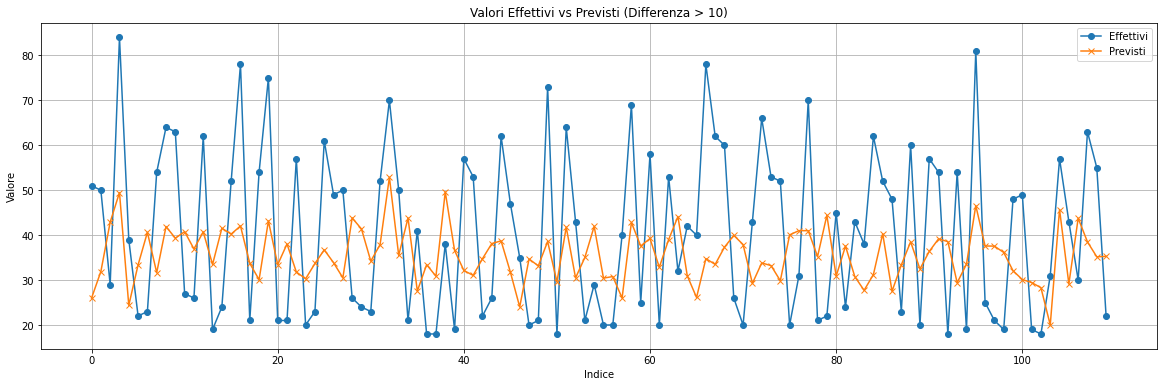

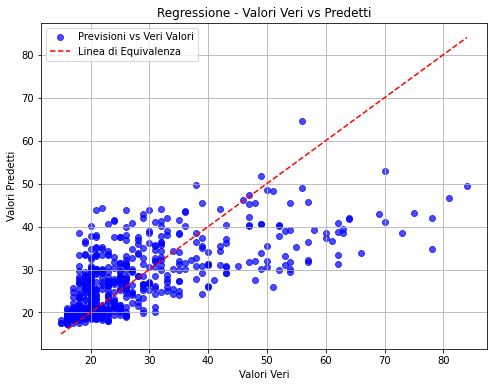

Fold 5:


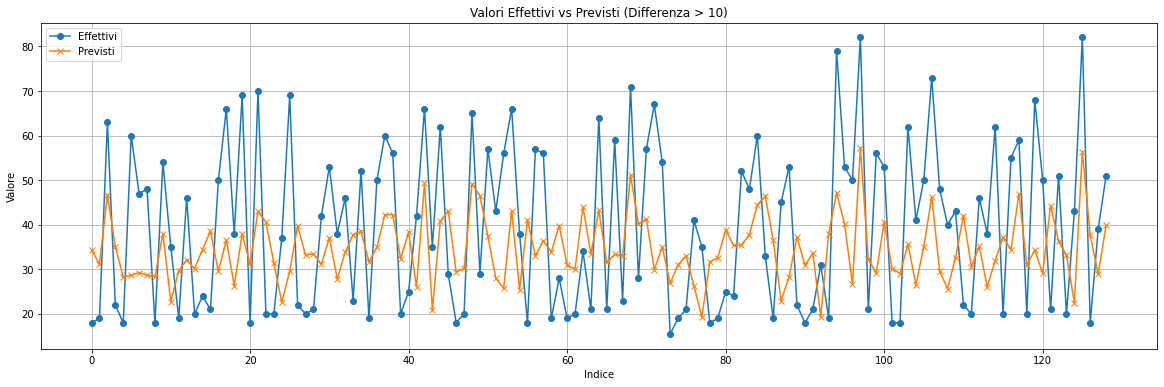

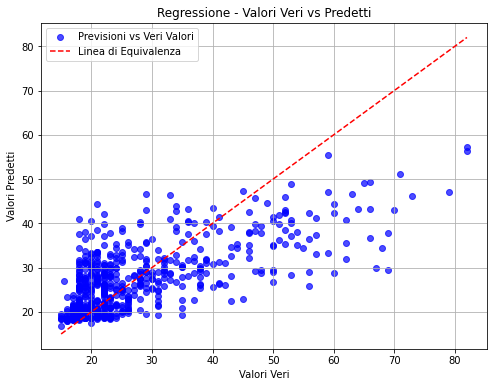

In [199]:
# Plot of the best model predictions
plot_previsioni(y_valid40,y_pred40)

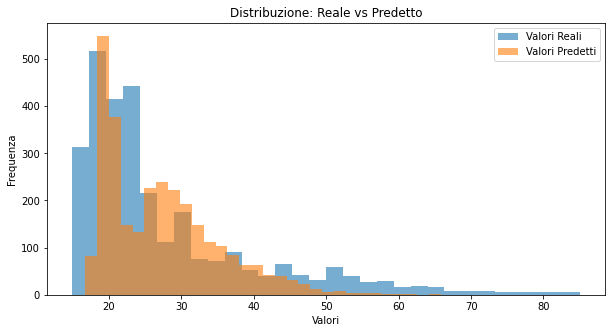


Analisi RMSE per fasce:
                   RMSE   count    weight  weighted_RMSE
y_bin                                                   
[15.0, 22.8]   6.317577  1428.0  0.488038       3.083219
[22.8, 30.6]   6.066212   698.0  0.238551       1.447100
[30.6, 38.3]   7.059922   304.0  0.103896       0.733498
[38.3, 46.1]  10.612693   179.0  0.061176       0.649239
[46.1, 53.9]  14.868779   137.0  0.046822       0.696180
[53.9, 61.7]  21.456892    91.0  0.031100       0.667320
[61.7, 69.4]  28.113686    49.0  0.016746       0.470803
[69.4, 77.2]  30.061443    23.0  0.007861       0.236300
[77.2, 85.0]  36.898356    17.0  0.005810       0.214379


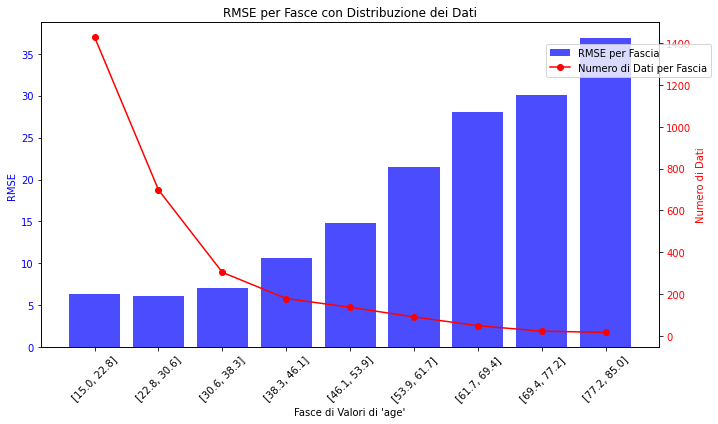

In [200]:
def plot_previsioni2(y_valid_lista,y_pred_lista):

    y_valid_concat = pd.concat(y_valid_lista)
    y_pred_concat = np.concatenate(y_pred_lista)
    residuals = y_valid_concat - y_pred_concat

    plt.figure(figsize=(10, 5))
    plt.hist(y_valid_concat, bins=30, alpha=0.6, label="Valori Reali")
    plt.hist(y_pred_concat, bins=30, alpha=0.6, label="Valori Predetti")
    plt.xlabel("Valori")
    plt.ylabel("Frequenza")
    plt.title("Distribuzione: Reale vs Predetto")
    plt.legend()
    plt.show()

    bins = np.linspace(y_valid_concat.min(), y_valid_concat.max(), 10)
    bin_labels = [f"[{round(bins[i], 1)}, {round(bins[i + 1], 1)}]" for i in range(len(bins) - 1)]
    y_bins = pd.cut(y_valid_concat, bins=bins, labels=bin_labels, include_lowest=True)

    bin_analysis = (
    pd.DataFrame({"y_true": y_valid_concat, "y_pred": y_pred_concat, "y_bin": y_bins})
    .groupby("y_bin")
    .apply(lambda group: pd.Series({
        "RMSE": sqrt(mean_squared_error(group["y_true"], group["y_pred"])),
        "count": len(group),
    }))
    )
  
    bin_analysis["weight"] = bin_analysis["count"] / bin_analysis["count"].sum()
    bin_analysis["weighted_RMSE"] = bin_analysis["weight"] * bin_analysis["RMSE"]
    weighted_rmse = bin_analysis["weighted_RMSE"].sum()

    print("\nAnalisi RMSE per fasce:")
    print(bin_analysis)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(bin_analysis.index, bin_analysis["RMSE"], alpha=0.7, color="blue", label="RMSE per Fascia")
    ax1.set_ylabel("RMSE", color="blue")
    ax1.set_xlabel("Fasce di Valori di 'age'")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.set_xticklabels(bin_analysis.index, rotation=45)
 
    ax2 = ax1.twinx()
    ax2.plot(bin_analysis.index, bin_analysis["count"], color="red", marker="o", label="Numero di Dati per Fascia")
    ax2.set_ylabel("Numero di Dati", color="red")
    ax2.tick_params(axis='y', labelcolor="red")

    plt.title("RMSE per Fasce con Distribuzione dei Dati")
    fig.tight_layout()
    fig.legend(loc="upper right", bbox_to_anchor=(1, 0.9))
    plt.show()
    

plot_previsioni2(y_valid40,y_pred40)

The plots presented compare the predicted ages with the true ages across the five cross-validation folds. A key observation is that while the model performs well for younger speakers, it tends to underestimate the ages of individuals over 50 years old. This systematic underprediction is likely due to the limited number of samples available in this age range, making it difficult for the model to learn accurate patterns for older speakers. In contrast, the predictions for younger individuals are more precise, as the dataset contains a larger and more diverse set of training examples for these age groups.

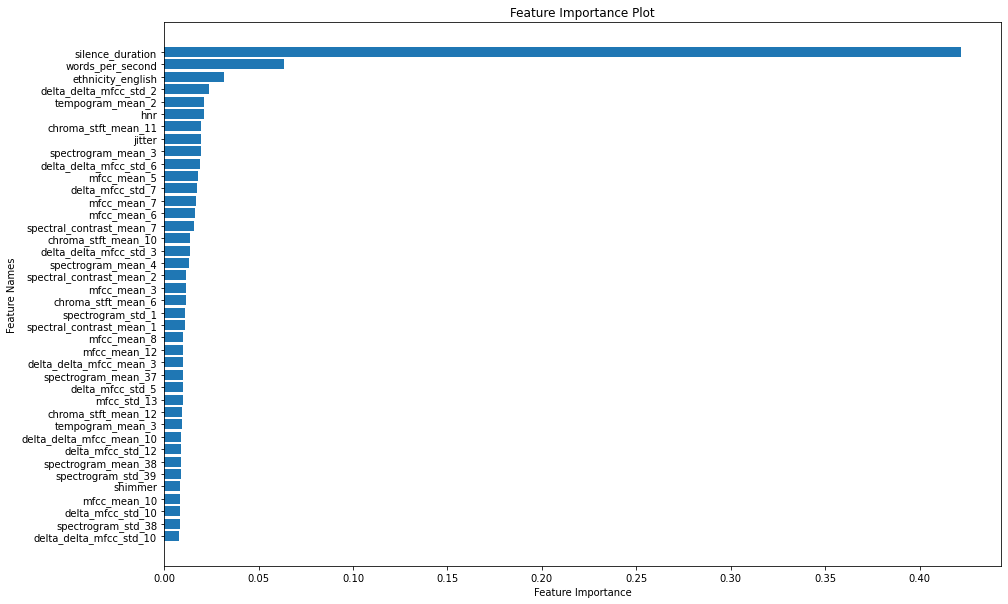

In [201]:
### FEATURE IMPORTANCE
copia=df_ridotto_40.copy()
copia=copia.drop(columns=['age'])
feature_names = copia.columns
sorted_features = sorted(zip(feature_names, reg_top40.feature_importances_), key=lambda x: x[1],reverse=True)
sorted_feature_names, sorted_importances = zip(*sorted_features)
plt.figure(figsize=(15,10))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()
plt.show()

## Grid Search for hyperparameter tuning

To further optimize our Random Forest Regressor, we implemented a grid search to fine-tune the model’s hyperparameters. This process was carried out using both the training and validation sets, ensuring that we leveraged the maximum amount of available data to train the final model. We show below the best hyperparameters found during the grid search. 

Finally, using the trained model, we created the submission.csv file containing the predicted ages for the test set. From this submission, we obtained a final evaluation score of (...)


In [202]:
def grid_search(df,param_grid, n_splits=5, random_state=0):
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]
    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    y_train_transformed = np.log1p(y_train_valid)

    reg = RandomForestRegressor(random_state=random_state)
    threshold_max = 40
    weights = np.where(y_train_valid > threshold_max, 4, 1) 
    grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=n_splits, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_valid, y_train_transformed, sample_weight=weights)
    best_reg = grid_search.best_estimator_
    print(f" Best Parameters: {grid_search.best_params_}")   
    
    return best_reg

from sklearn.model_selection import GridSearchCV


def grid_search_reg(df,param_grid,reg, n_splits=5, random_state=0):

    train = df[df['age'].notna()]
    test = df[df['age'].isna()]
    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    y_train_transformed = np.log1p(y_train_valid)

    threshold_max = 40
    weights = np.where(y_train_valid > threshold_max, 4, 1) 
    grid_search =  GridSearchCV(estimator=reg, param_grid=param_grid, cv=n_splits,scoring='neg_mean_squared_error')
    grid_search.fit(X_train_valid, y_train_transformed, sample_weight=weights)
    best_reg = grid_search.best_estimator_
    print(f" Best Parameters: {grid_search.best_params_}")   
    
    return best_reg




In [ ]:
reg = RandomForestRegressor(random_state=0)

param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, None],
    'min_samples_leaf': [2, 5],
}

best_reg=grid_search_reg(df_ridotto_40,param_grid,reg)
# Best Parameters: "{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 1000}",
       

In [ ]:
### OUTPUT
train = df_finale[df_ridotto_40['age'].notna()]
test = df_finale[df_ridotto_40['age'].isna()]
X_train=train.drop(columns=['age'])
X_test=test.drop(columns=['age'])
y_train=train['age']
weights = np.where(y_train > 40, 4, 1)
y_train_trasformed= np.log1p(y_train)
best_reg.fit(X_train, y_train_trasformed,sample_weight=weights)
y_pred_transformed = best_reg.predict(X_test)
y_pred = np.expm1(y_pred_transformed)


submission=pd.DataFrame({
    "Id": range(len(df_eval)),
    "Predicted": y_pred
})

submission.to_csv('submission_RFG.csv',index=False)


### Gradient Boosting Regressor

After optimizing the Random Forest Regressor, we aimed to fit a more complex and potentially more performant model. For this reason, we explored the Gradient Boosting Regressor (GBR), a powerful ensemble learning technique that builds upon the strengths of decision trees while addressing some of their limitations.

#### How Gradient Boosting Works and Why It Can Improve Performance

Gradient Boosting operates by training a sequence of weak learners, typically decision trees, where each subsequent tree corrects the errors made by the previous ones. Unlike Random Forest, which builds independent trees in parallel and averages their predictions, Gradient Boosting builds trees sequentially, with each new tree focusing on reducing the residual errors of the previous model. This iterative learning process allows the model to capture complex patterns and relationships in the data, often leading to improved accuracy.


In [203]:
### GRADIENT BOOSTING

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def gradient_boosting_semplice(df, n_splits=5, random_state=0):

    train = df[df['age'].notna()]
    test = df[df['age'].isna()]

    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])
    
    r2_scores = []
    rmses = []
    y_valid_lista = []
    y_pred_lista = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)

        X_train = pd.DataFrame(X_train, columns=X_train_valid.columns)
        X_valid = pd.DataFrame(X_valid, columns=X_train_valid.columns)

        reg=GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=0)

        threshold_max = 40
        threshold_min = 1
        weights = np.where(y_train > threshold_max, (y_train / threshold_max) ** 2, 1)
        y_train_transformed = np.log1p(y_train)

        reg.fit(X_train, y_train_transformed, sample_weight=weights)

        y_pred_transformed = reg.predict(X_valid)

        y_pred = np.expm1(y_pred_transformed)
        y_pred_lista.append(np.array(y_pred))

        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2)
        rmses.append(rmse)

        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    return reg, y_valid_lista, y_pred_lista


In [204]:
gradient_boosting_semplice(df_ridotto_40)

print()

Fold 1: r2_score = 0.4405, RMSE = 9.0523
Fold 2: r2_score = 0.3791, RMSE = 11.0703
Fold 3: r2_score = 0.4074, RMSE = 9.8742
Fold 4: r2_score = 0.4449, RMSE = 9.1972
Fold 5: r2_score = 0.4851, RMSE = 9.1499

Mean r2_score: 0.4314
Mean RMSE: 9.6688



In [206]:

def gradient_boosting_reg(df,reg,scala=True, n_splits=5, random_state=0):
    reg_copy = copy.deepcopy(reg)
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]
    X_train_valid = train.drop(columns=["age"])
    y_train_valid = train["age"]
    X_test = test.drop(columns=["age"])
    
    r2_scores = []
    rmses = []
    y_valid_lista = []
    y_pred_lista = []
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid)):
        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)

        if scala:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_valid = scaler.transform(X_valid)

            X_train = pd.DataFrame(X_train, columns=X_train_valid.columns)
            X_valid = pd.DataFrame(X_valid, columns=X_train_valid.columns)

        threshold_max=40
        weights = np.where(y_train > threshold_max, 4, 1)

        y_train_transformed = np.log1p(y_train)
        reg.fit(X_train, y_train_transformed, sample_weight=weights)

        y_pred_transformed = reg.predict(X_valid)

        y_pred = np.expm1(y_pred_transformed)
        y_pred_lista.append(np.array(y_pred))

        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2)
        rmses.append(rmse)

        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    
    weights = np.where(y_train_valid > threshold_max, 4, 1)
    y_train_transformed= np.log1p(y_train_valid)
    reg_copy.fit(X_train_valid, y_train_transformed,sample_weight=weights)
    
    return reg_copy, y_valid_lista, y_pred_lista

def gradient_boosting_stratified(df,reg,scala=True, n_splits=5, random_state=0):
    reg_copy = copy.deepcopy(reg)
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]
    
    train.loc[:, 'label_age'] = pd.cut(train.loc[:, 'age'], bins=[-np.inf, 20, 30, 40, 50, 60, 70, 80, np.inf], labels=[0, 1, 2, 3, 4, 5, 6, 7])
    X_train_valid = train.drop(columns=["age","label_age"])
    y_train_valid = train["age"]
    label_age= train["label_age"]
    X_test = test.drop(columns=["age"])

    kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    y_valid_lista = []
    y_pred_lista = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid,label_age)):

        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)

        if scala:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_valid = scaler.transform(X_valid)

            X_train = pd.DataFrame(X_train, columns=X_train_valid.columns)
            X_valid = pd.DataFrame(X_valid, columns=X_train_valid.columns)
        

        threshold_max=40
        weights = np.where(y_train > threshold_max, 4, 1)
        y_train_transformed = np.log1p(y_train)
        reg.fit(X_train, y_train_transformed, sample_weight=weights)

        y_pred_transformed = reg.predict(X_valid)
        y_pred = np.expm1(y_pred_transformed)
        y_pred_lista.append(np.array(y_pred))

        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2)
        rmses.append(rmse)

        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")

    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")

    weights = np.where(y_train_valid > threshold_max, 4, 1)
    y_train_transformed= np.log1p(y_train_valid)
    reg_copy.fit(X_train_valid, y_train_transformed,sample_weight=weights)
    return reg_copy, y_valid_lista, y_pred_lista


#### Implementation and Results

To begin our exploration, we implemented a basic Gradient Boosting Regressor with 200 estimators using the top 40 features previously selected with the Random Forest Regressor. The results obtained were similar to those of the Random Forest model, indicating that while the method was promising, further tuning was required.

Recognizing the potential of Gradient Boosting, we refined our approach by experimenting with more sophisticated hyperparameters, including learning rate, maximum depth, and an higher number of estimators. This more advanced tuning led to a significant reduction in RMSE, confirming the effectiveness of Gradient Boosting when properly optimized. Encouraged by this improvement, we decided to explore the method in greater detail, aiming to further enhance performance and push the model to its optimal capacity.


In [207]:
reg = GradientBoostingRegressor(
            n_estimators=1000,  
            learning_rate=0.01,  
            max_depth=6,  
            min_samples_leaf=5,  
            subsample=0.8, 
            random_state=0
        )

gradient_boosting_reg(df_ridotto_40,reg,scala=False)
gradient_boosting_stratified(df_ridotto_40,reg,scala=False)
print()

Fold 1: r2_score = 0.4819, RMSE = 8.7114
Fold 2: r2_score = 0.3977, RMSE = 10.9032
Fold 3: r2_score = 0.4485, RMSE = 9.5258
Fold 4: r2_score = 0.4700, RMSE = 8.9870
Fold 5: r2_score = 0.4987, RMSE = 9.0287

Mean r2_score: 0.4594
Mean RMSE: 9.4312
Fold 1: r2_score = 0.4397, RMSE = 9.5209
Fold 2: r2_score = 0.4852, RMSE = 9.2170
Fold 3: r2_score = 0.4681, RMSE = 9.4265
Fold 4: r2_score = 0.4596, RMSE = 9.4240
Fold 5: r2_score = 0.4881, RMSE = 9.2352

Mean r2_score: 0.4682
Mean RMSE: 9.3647



Following the same approach used for the Random Forest Regressor, we trained the Gradient Boosting Regressor on the dataset containing all available features. By examining the feature importances provided by the trained Gradient Boosting model, we identified the most influential attributes contributing to age estimation. Using this information, we selected a subset of the most relevant features and retrained the model, testing different feature set sizes to find the optimal balance between complexity and predictive performance.

In [208]:
print('\n Gradient boosting k fold: ')
reg1,y_valid1,y_pred1=gradient_boosting_reg(dataset_completo,reg,scala=False)
print('\n  Gradient boosting k fold stratificato: ')
reg2,y_valid2,y_pred2=gradient_boosting_stratified(dataset_completo,reg,scala=False)

print()



 Gradient boosting k fold: 
Fold 1: r2_score = 0.4630, RMSE = 8.8689
Fold 2: r2_score = 0.3847, RMSE = 11.0201
Fold 3: r2_score = 0.4559, RMSE = 9.4621
Fold 4: r2_score = 0.4556, RMSE = 9.1082
Fold 5: r2_score = 0.4899, RMSE = 9.1076

Mean r2_score: 0.4498
Mean RMSE: 9.5134

  Gradient boosting k fold stratificato: 
Fold 1: r2_score = 0.3994, RMSE = 9.8574
Fold 2: r2_score = 0.4859, RMSE = 9.2107
Fold 3: r2_score = 0.4737, RMSE = 9.3772
Fold 4: r2_score = 0.4596, RMSE = 9.4236
Fold 5: r2_score = 0.4701, RMSE = 9.3957

Mean r2_score: 0.4578
Mean RMSE: 9.4529



In [209]:
num_features=40
df_top_features40, top_features_40,feature_importances1 = top_features_df(dataset_completo, reg1, num_features) # Mean RMSE: 9.4662 con num_features=40
num_features=30
df_top_features30, top_features_30,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)
num_features=50
df_top_features50, top_features_50,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)
num_features=60
df_top_features60, top_features_60,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)

In [210]:
top_features30=top_features_30.copy().tolist()
top_features30.append('age')
df_ridotto_30=dataset_completo.loc[:, top_features30]

top_features40=top_features_40.copy().tolist()
top_features40.append('age')
df_ridotto_40=dataset_completo.loc[:, top_features40]

top_features50=top_features_50.copy().tolist()
top_features50.append('age')
df_ridotto_50=dataset_completo.loc[:, top_features50]

top_features60=top_features_60.copy().tolist()
top_features60.append('age')
df_ridotto_60=dataset_completo.loc[:, top_features60]


In [211]:
print('30')
reg_top30,y_valid30,y_pred30=gradient_boosting_reg(df_ridotto_30,reg,scala=False)
gradient_boosting_stratified(df_ridotto_30,reg,scala=False)
print('40')
reg_top40,y_valid40,y_pred40=gradient_boosting_reg(df_ridotto_40,reg,scala=False)
gradient_boosting_stratified(df_ridotto_40,reg,scala=False)
print('50')
reg_top50,y_valid50,y_pred50=gradient_boosting_reg(df_ridotto_50,reg,scala=False)
gradient_boosting_stratified(df_ridotto_50,reg,scala=False)
print('60')
reg_top60,y_valid60,y_pred60=gradient_boosting_reg(df_ridotto_60,reg,scala=False)
gradient_boosting_stratified(df_ridotto_60,reg,scala=False)

print()

30
Fold 1: r2_score = 0.4740, RMSE = 8.7774
Fold 2: r2_score = 0.4037, RMSE = 10.8488
Fold 3: r2_score = 0.4546, RMSE = 9.4735
Fold 4: r2_score = 0.4506, RMSE = 9.1496
Fold 5: r2_score = 0.4913, RMSE = 9.0950

Mean r2_score: 0.4548
Mean RMSE: 9.4689
Fold 1: r2_score = 0.4311, RMSE = 9.5944
Fold 2: r2_score = 0.4998, RMSE = 9.0854
Fold 3: r2_score = 0.4577, RMSE = 9.5183
Fold 4: r2_score = 0.4575, RMSE = 9.4421
Fold 5: r2_score = 0.4788, RMSE = 9.3189

Mean r2_score: 0.4650
Mean RMSE: 9.3918
40
Fold 1: r2_score = 0.4857, RMSE = 8.6790
Fold 2: r2_score = 0.3927, RMSE = 10.9486
Fold 3: r2_score = 0.4628, RMSE = 9.4013
Fold 4: r2_score = 0.4461, RMSE = 9.1870
Fold 5: r2_score = 0.5038, RMSE = 8.9830

Mean r2_score: 0.4582
Mean RMSE: 9.4398
Fold 1: r2_score = 0.4481, RMSE = 9.4496
Fold 2: r2_score = 0.5008, RMSE = 9.0762
Fold 3: r2_score = 0.4794, RMSE = 9.3261
Fold 4: r2_score = 0.4615, RMSE = 9.4071
Fold 5: r2_score = 0.4851, RMSE = 9.2625

Mean r2_score: 0.4750
Mean RMSE: 9.3043
50
Fold 

In [212]:
num_features=70
df_top_features70, top_features_70,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)
num_features=80
df_top_features80, top_features_80,feature_importances1 = top_features_df(dataset_completo, reg1, num_features)

top_features70=top_features_70.copy().tolist()
top_features70.append('age')
df_ridotto_70=dataset_completo.loc[:, top_features70]
top_features80=top_features_80.copy().tolist()
top_features80.append('age')
df_ridotto_80=dataset_completo.loc[:, top_features80]

In [213]:
print('70')
reg_top70,y_valid70,y_pred70=gradient_boosting_reg(df_ridotto_70,reg,scala=False)
gradient_boosting_stratified(df_ridotto_70,reg,scala=False)
print('80')
reg_top80,y_valid80,y_pred80=gradient_boosting_reg(df_ridotto_80,reg,scala=False)
gradient_boosting_stratified(df_ridotto_80,reg,scala=False)

print()

70
Fold 1: r2_score = 0.4888, RMSE = 8.6532
Fold 2: r2_score = 0.4066, RMSE = 10.8222
Fold 3: r2_score = 0.4681, RMSE = 9.3554
Fold 4: r2_score = 0.4701, RMSE = 8.9861
Fold 5: r2_score = 0.4948, RMSE = 9.0634

Mean r2_score: 0.4657
Mean RMSE: 9.3761
Fold 1: r2_score = 0.4227, RMSE = 9.6647
Fold 2: r2_score = 0.4988, RMSE = 9.0946
Fold 3: r2_score = 0.4867, RMSE = 9.2602
Fold 4: r2_score = 0.4692, RMSE = 9.3397
Fold 5: r2_score = 0.4981, RMSE = 9.1447

Mean r2_score: 0.4751
Mean RMSE: 9.3008
80
Fold 1: r2_score = 0.4759, RMSE = 8.7612
Fold 2: r2_score = 0.4100, RMSE = 10.7912
Fold 3: r2_score = 0.4787, RMSE = 9.2614
Fold 4: r2_score = 0.4802, RMSE = 8.8997
Fold 5: r2_score = 0.4981, RMSE = 9.0339

Mean r2_score: 0.4686
Mean RMSE: 9.3495
Fold 1: r2_score = 0.4180, RMSE = 9.7038
Fold 2: r2_score = 0.4979, RMSE = 9.1028
Fold 3: r2_score = 0.4882, RMSE = 9.2465
Fold 4: r2_score = 0.4709, RMSE = 9.3248
Fold 5: r2_score = 0.4960, RMSE = 9.1632

Mean r2_score: 0.4742
Mean RMSE: 9.3082



In [216]:

df_finale=df_ridotto_60

#### Final Model Optimization and Grid Search for Gradient Boosting

After refining the feature selection process, we experimented with different Gradient Boosting configurations, testing various hyperparameters to better understand their impact on model performance. Based on these insights, we designed a reasonable grid search to optimize the most influential hyperparameters. As before, we conducted this grid search using the top features identified in the previous step, training the model on the entire set of labeled data (both training and validation sets) to maximize learning potential. Once the optimal hyperparameters were identified, we trained the final model and generated predictions for the test set, creating the new submission.csv file. From this submission, we obtained a final RMSE of (...), showing the effectiveness of our refined Gradient Boosting approach and optimized feature selection.

In [ ]:
param_grid = {
    'n_estimators': [1000, 2000, 2500],
    'learning_rate': [0.005, 0.01],
    'max_depth': [4, 6],
    'min_samples_leaf': [5, 10],
    'subsample': [0.6, 0.8],
    'max_features': ['sqrt', 'log2']
}

reg = GradientBoostingRegressor(random_state=0)
best_reg=grid_search_reg(df_finale,param_grid,reg)
print(best_reg)

# Best Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 2500, 'subsample': 0.8} 

In [ ]:
### OUTPUT
train = df_finale[df_ridotto_60['age'].notna()]
test = df_finale[df_ridotto_60['age'].isna()]
X_train=train.drop(columns=['age'])
X_test=test.drop(columns=['age'])
y_train=train['age']
weights = np.where(y_train > 40, 4, 1)
y_train_trasformed= np.log1p(y_train)
best_reg.fit(X_train, y_train_trasformed,sample_weight=weights)
y_pred_transformed = best_reg.predict(X_test)
y_pred = np.expm1(y_pred_transformed)


submission=pd.DataFrame({
    "Id": range(len(df_eval)),
    "Predicted": y_pred
})

submission.to_csv('submission_GBR.csv',index=False)

### XGBoost

XGBoost (Extreme Gradient Boosting) is an advanced machine learning algorithm based on the gradient boosting framework. It is designed to be highly efficient, scalable, and optimized for performance, making it one of the most powerful and widely used models for regression and classification tasks. 

XGBoost introduces several improvements over standard Gradient Boosting, including regularization techniques, optimized computation methods, and parallel processing, which help prevent overfitting and improve predictive accuracy. Unlike standard Gradient Boosting, which grows trees depth-wise, XGBoost grows trees leaf-wise, meaning it expands the leaf with the highest loss reduction rather than growing all branches evenly. This approach allows XGBoost to focus on the most critical splits, leading to faster convergence and better predictive performance, though it requires careful regularization to prevent overfitting. XGBoost improves upon traditional Gradient Boosting by introducing regularization (L1 & L2 penalties) that helps prevent overfitting.


In [217]:
from xgboost import XGBRegressor

def Xgradient_boosting_stratified(df,reg,scala=True, n_splits=5, random_state=0):
    reg_copy = copy.deepcopy(reg)
    train = df[df['age'].notna()]
    test = df[df['age'].isna()]
    
    train.loc[:, 'label_age'] = pd.cut(train.loc[:, 'age'], bins=[-np.inf, 20, 30, 40, 50, 60, 70, 80, np.inf], labels=[0, 1, 2, 3, 4, 5, 6, 7])
    X_train_valid = train.drop(columns=["age","label_age"])
    y_train_valid = train["age"]
    label_age= train["label_age"]
    X_test = test.drop(columns=["age"])

    kf = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=random_state)
    
    r2_scores = []
    rmses = []
    y_valid_lista = []
    y_pred_lista = []
    
    for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train_valid,label_age)):

        X_train, X_valid = X_train_valid.iloc[train_idx], X_train_valid.iloc[valid_idx]
        y_train, y_valid = y_train_valid.iloc[train_idx], y_train_valid.iloc[valid_idx]
        y_valid_lista.append(y_valid)

        if scala:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_valid = scaler.transform(X_valid)

            X_train = pd.DataFrame(X_train, columns=X_train_valid.columns)
            X_valid = pd.DataFrame(X_valid, columns=X_train_valid.columns)
        

        threshold_max=40
        weights = np.where(y_train > threshold_max, 4, 1)

        y_train_transformed = np.log1p(y_train)

        reg.fit(X_train, y_train_transformed, sample_weight=weights)

        y_pred_transformed = reg.predict(X_valid)

        y_pred = np.expm1(y_pred_transformed)
        y_pred_lista.append(np.array(y_pred))

        r2 = r2_score(y_valid, y_pred)
        rmse = sqrt(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2)
        rmses.append(rmse)

        print(f"Fold {fold + 1}: r2_score = {r2:.4f}, RMSE = {rmse:.4f}")
    
    mean_r2 = np.mean(r2_scores)
    mean_rmse = np.mean(rmses)
    print(f"\nMean r2_score: {mean_r2:.4f}")
    print(f"Mean RMSE: {mean_rmse:.4f}")

    weights = np.where(y_train_valid > threshold_max, 4, 1)
    y_train_transformed= np.log1p(y_train_valid)
    reg_copy.fit(X_train_valid, y_train_transformed,sample_weight=weights)
    return reg_copy, y_valid_lista, y_pred_lista


xbg=XGBRegressor( n_estimators=1000,  
            learning_rate=0.01, 
            max_depth=6,  
            min_samples_leaf=5,  
            subsample=0.8, 
            random_state=0,
            reg_lamda=1,
            reg_alpha=0.5
        )

xb_reg, xb_y_valid_lista, xb_y_pred_lista=Xgradient_boosting_stratified(df_finale,xbg,scala=False)
print()

Fold 1: r2_score = 0.4536, RMSE = 9.4026
Fold 2: r2_score = 0.5088, RMSE = 9.0031
Fold 3: r2_score = 0.4861, RMSE = 9.2660
Fold 4: r2_score = 0.4648, RMSE = 9.3782
Fold 5: r2_score = 0.4961, RMSE = 9.1630

Mean r2_score: 0.4819
Mean RMSE: 9.2426



In [218]:
print('\n  XGradient boosting k fold stratificato: ')
reg2,y_valid2,y_pred2=Xgradient_boosting_stratified(dataset_completo,xbg,scala=False)


  XGradient boosting k fold stratificato: 
Fold 1: r2_score = 0.4091, RMSE = 9.7774
Fold 2: r2_score = 0.4850, RMSE = 9.2189
Fold 3: r2_score = 0.4658, RMSE = 9.4474
Fold 4: r2_score = 0.4635, RMSE = 9.3903
Fold 5: r2_score = 0.4562, RMSE = 9.5188

Mean r2_score: 0.4559
Mean RMSE: 9.4706


As we did before, we explored the efficiency of the XGBoost Regressor through a comparative analysis with respect to the Gradient Boosting. We then trained a model on the full dataset to identify the most relevant features, selecting only the most important ones to reduce dimensionality and improve generalization. Finally, we conducted a grid search to optimize hyperparameters, following the same approach used previously, to further enhance the model’s performance.

In [219]:
num_features=40
df_top_features40, top_features_40,feature_importances1 = top_features_df(dataset_completo, reg2, num_features) 
num_features=50
df_top_features50, top_features_50,feature_importances1 = top_features_df(dataset_completo, reg2, num_features)
num_features=60
df_top_features60, top_features_60,feature_importances1 = top_features_df(dataset_completo, reg2, num_features)

In [220]:
top_features40=top_features_40.copy().tolist()
top_features40.append('age')
df_ridotto_40=dataset_completo.loc[:, top_features40]

top_features50=top_features_50.copy().tolist()
top_features50.append('age')
df_ridotto_50=dataset_completo.loc[:, top_features50]

top_features60=top_features_60.copy().tolist()
top_features60.append('age')
df_ridotto_60=dataset_completo.loc[:, top_features60]

In [221]:
print('40')
reg_top40,y_valid40,y_pred40=Xgradient_boosting_stratified(df_ridotto_40,xbg,scala=False)
print('50')
reg_top50,y_valid50,y_pred50=Xgradient_boosting_stratified(df_ridotto_50,xbg,scala=False)
print('60')
xb_reg_top60,xb_y_valid60,xb_y_pred60=Xgradient_boosting_stratified(df_ridotto_60,xbg,scala=False)

40
Fold 1: r2_score = 0.4305, RMSE = 9.5994
Fold 2: r2_score = 0.5067, RMSE = 9.0226
Fold 3: r2_score = 0.4579, RMSE = 9.5169
Fold 4: r2_score = 0.4502, RMSE = 9.5059
Fold 5: r2_score = 0.4704, RMSE = 9.3933

Mean r2_score: 0.4631
Mean RMSE: 9.4076
50
Fold 1: r2_score = 0.4567, RMSE = 9.3754
Fold 2: r2_score = 0.5202, RMSE = 8.8983
Fold 3: r2_score = 0.4787, RMSE = 9.3319
Fold 4: r2_score = 0.4825, RMSE = 9.2222
Fold 5: r2_score = 0.4870, RMSE = 9.2450

Mean r2_score: 0.4850
Mean RMSE: 9.2145
60
Fold 1: r2_score = 0.4510, RMSE = 9.4245
Fold 2: r2_score = 0.5188, RMSE = 8.9112
Fold 3: r2_score = 0.4823, RMSE = 9.2998
Fold 4: r2_score = 0.4858, RMSE = 9.1930
Fold 5: r2_score = 0.4840, RMSE = 9.2719

Mean r2_score: 0.4844
Mean RMSE: 9.2201


In [222]:
num_features=70
df_top_features70, top_features_70,feature_importances1 = top_features_df(dataset_completo, reg2, num_features)
num_features=80
df_top_features80, top_features_80,feature_importances1 = top_features_df(dataset_completo, reg2, num_features)

top_features70=top_features_70.copy().tolist()
top_features70.append('age')
df_ridotto_70=dataset_completo.loc[:, top_features70]
top_features80=top_features_80.copy().tolist()
top_features80.append('age')
df_ridotto_80=dataset_completo.loc[:, top_features80]

In [223]:
print('70')
reg_top70,y_valid70,y_pred70=Xgradient_boosting_stratified(df_ridotto_70,xbg,scala=False)
print('80')
xb_reg_top80,xb_y_valid80,xb_y_pred80=Xgradient_boosting_stratified(df_ridotto_80,xbg,scala=False)

print()

70
Fold 1: r2_score = 0.4482, RMSE = 9.4487
Fold 2: r2_score = 0.5185, RMSE = 8.9140
Fold 3: r2_score = 0.4842, RMSE = 9.2827
Fold 4: r2_score = 0.4778, RMSE = 9.2638
Fold 5: r2_score = 0.4978, RMSE = 9.1473

Mean r2_score: 0.4853
Mean RMSE: 9.2113
80
Fold 1: r2_score = 0.4435, RMSE = 9.4890
Fold 2: r2_score = 0.5129, RMSE = 8.9657
Fold 3: r2_score = 0.4927, RMSE = 9.2061
Fold 4: r2_score = 0.4855, RMSE = 9.1953
Fold 5: r2_score = 0.4893, RMSE = 9.2245

Mean r2_score: 0.4848
Mean RMSE: 9.2161



In [224]:
nuovo_dataset_finale=df_ridotto_70


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [500, 1000, 1500,2000],
    'learning_rate': [0.005, 0.01,0.05],
    'max_depth': [3, 6],
    'subsample': [0.8, 1],
    'reg_lamda':[0.1,1,10],
    'reg_alpha': [0,0.1,1],
    'min_child_weight': [3,5]
    
}

reg = XGBRegressor(random_state=0)
best_reg=grid_search_reg(nuovo_dataset_finale,param_grid,reg)
print(best_reg)
# Best Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 2000, 'reg_alpha': 0.1, 'reg_lamda': 0.1, 'subsample': 0.8}

In [225]:
best_reg=XGBRegressor(random_state=0,learning_rate= 0.01, max_depth= 6, min_child_weight=5, n_estimators=2000, reg_alpha= 0.1, reg_lamda= 0.1, subsample=0.8)


In [226]:
### OUTPUT
train = df_finale[nuovo_dataset_finale['age'].notna()]
test = df_finale[nuovo_dataset_finale['age'].isna()]
X_train=train.drop(columns=['age'])
X_test=test.drop(columns=['age'])
y_train=train['age']
weights = np.where(y_train > 40, 4, 1)
y_train_trasformed= np.log1p(y_train)
best_reg.fit(X_train, y_train_trasformed,sample_weight=weights)
y_pred_transformed = best_reg.predict(X_test)
y_pred = np.expm1(y_pred_transformed)


submission=pd.DataFrame({
    "Id": range(len(df_eval)),
    "Predicted": y_pred
})

submission.to_csv('submission_XGBR.csv',index=False)


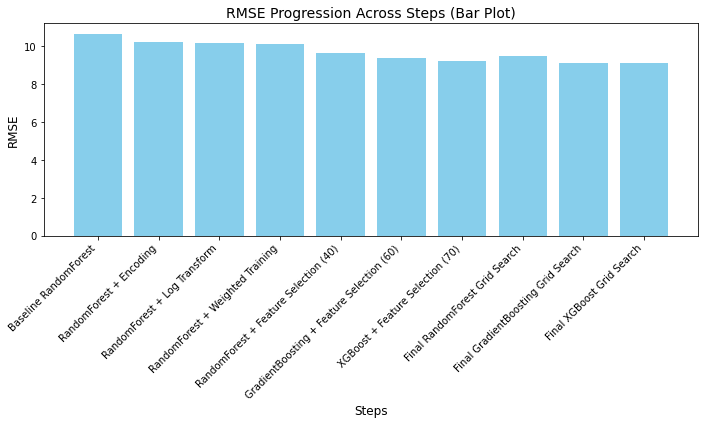

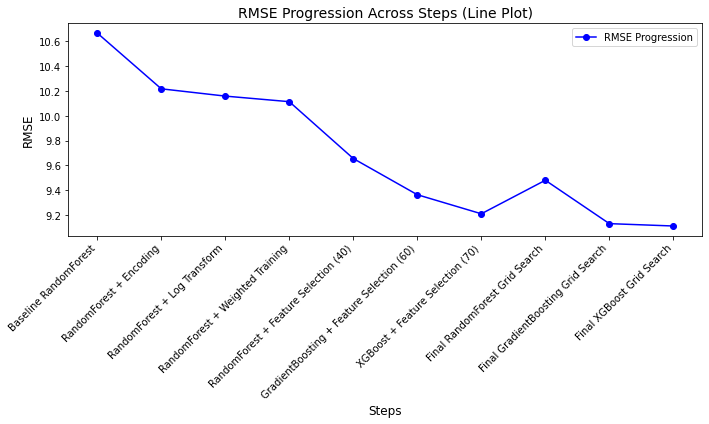

Model  \
0      RandomForestRegressor   
1  GradientBoostingRegressor   
2               XGBRegressor   

                                     Best Parameters   RMSE  
0  {'max_depth': 20, 'min_samples_leaf': 2, 'n_es...  9.481  
1  {'learning_rate': 0.01, 'max_depth': 6, 'max_f...  9.132  
2  {'learning_rate': 0.01, 'max_depth': 6, 'min_c...  9.113

In [227]:

# Data for the best hyperparameters and RMSE
best_params_data = {
    "Model": ["RandomForestRegressor", "GradientBoostingRegressor", "XGBRegressor"],
    "Best Parameters": [
        "{'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 1000}",
        "{'learning_rate': 0.01, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 2500, 'subsample': 0.8}",
        "{'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 2000, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}"
    ],
    "RMSE": [9.481, 9.132, 9.113]
}

# Convert to DataFrame for better visualization as a table
best_params_df = pd.DataFrame(best_params_data)

# Data for RMSE progression over steps
rmse_progression = {
    "Step": [
        "Baseline RandomForest",
        "RandomForest + Encoding",
        "RandomForest + Log Transform",
        "RandomForest + Weighted Training",
        "RandomForest + Feature Selection (40)",
        "GradientBoosting + Feature Selection (60)",
        "XGBoost + Feature Selection (70)",
        "Final RandomForest Grid Search",
        "Final GradientBoosting Grid Search",
        "Final XGBoost Grid Search"
    ],
    "RMSE": [
        10.6654, 10.2167, 10.1581, 10.1132, 9.6558, 9.3647, 9.2113, 9.481, 9.132, 9.113
    ]
}

# Convert to DataFrame for plotting
rmse_df = pd.DataFrame(rmse_progression)

# Bar plot of RMSE progression
plt.figure(figsize=(10, 6))
plt.bar(rmse_df["Step"], rmse_df["RMSE"], color="skyblue")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("RMSE Progression Across Steps (Bar Plot)", fontsize=14)
plt.tight_layout()
plt.show()

# Line plot of RMSE progression
plt.figure(figsize=(10, 6))
plt.plot(rmse_df["Step"], rmse_df["RMSE"], marker="o", color="blue", linestyle="-", label="RMSE Progression")
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.xlabel("Steps", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("RMSE Progression Across Steps (Line Plot)", fontsize=14)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# Display the table of best parameters
best_params_df


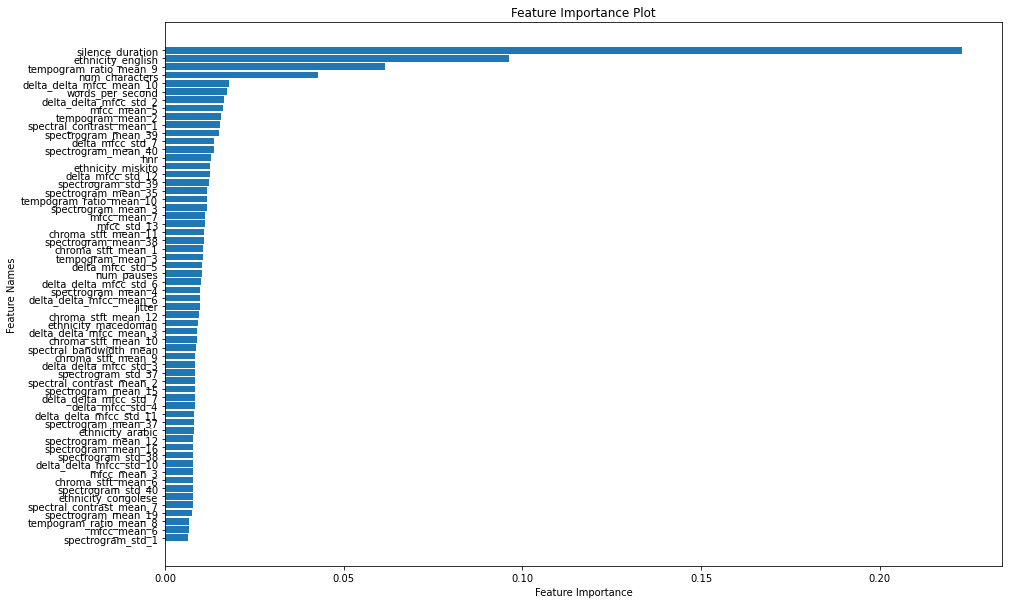

In [228]:
# Features Importance
copia=nuovo_dataset_finale.copy()
copia=copia.drop(columns=['age'])
feature_names = copia.columns
sorted_features = sorted(zip(feature_names, best_reg.feature_importances_), key=lambda x: x[1],reverse=True)
sorted_feature_names, sorted_importances = zip(*sorted_features)

plt.figure(figsize=(15,10))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()
plt.show()

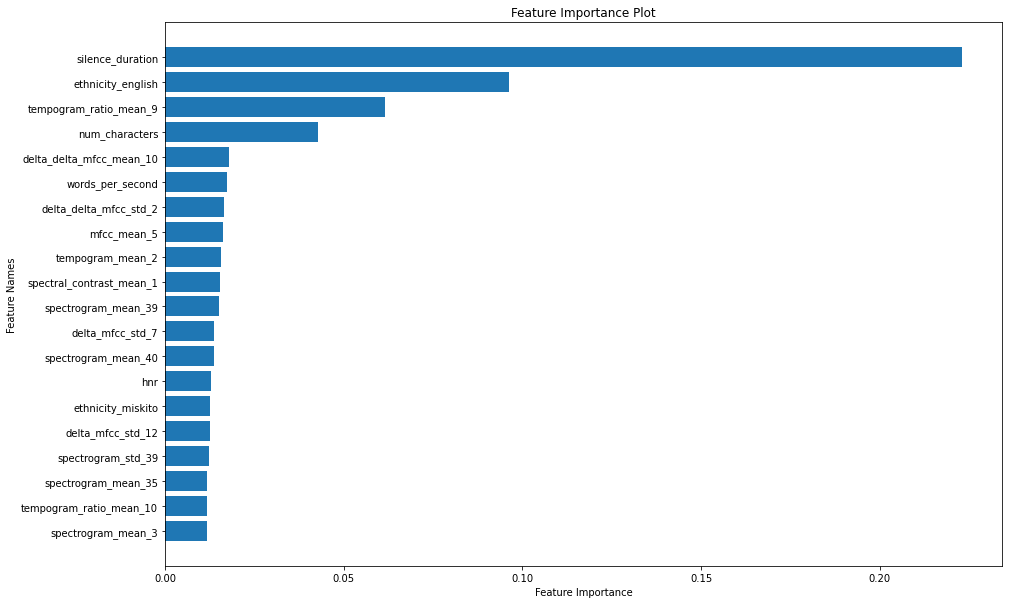

In [229]:
# Features Importance
copia=nuovo_dataset_finale.copy()
copia=copia.drop(columns=['age'])
feature_names = copia.columns
sorted_features = sorted(zip(feature_names, best_reg.feature_importances_), key=lambda x: x[1],reverse=True)

sorted_feature_names, sorted_importances = zip(*sorted_features[:20])

plt.figure(figsize=(15,10))
plt.barh(sorted_feature_names, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()
plt.show()